# Q1 Multi-Task CNN on Fashion-MNIST 

In [18]:
import hashlib
import numpy as np
import matplotlib.pyplot as plt
import wandb
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

import torch
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Dataset, Subset, random_split
import torchvision.transforms.v2 as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

print(f"PyTorch version: {torch.__version__}")
print(f"Torchvision version: {torchvision.__version__}")

if torch.cuda.is_available():
    print("GPU is available!")
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
    device = torch.device("cuda")
else:
    print("GPU not available. Using CPU.")
    device = torch.device("cpu")

PyTorch version: 2.5.1+cu121
Torchvision version: 0.20.1+cu121
GPU is available!
Using GPU: NVIDIA GeForce RTX 4060 Laptop GPU


In [21]:
# Using SHA-256 to generate unique seed
username = "m.samartha"
seed = int( hashlib.sha256(username.encode()).hexdigest(),16) % (2**32)
print(seed)
np.random.seed(seed)

def add_username(username = "m.samartha") -> None:
    plt.text(0.95, 0.95, username, ha="right", va="top", transform=plt.gca().transAxes, fontsize=10, color="gray", alpha=0.7)

def add_username_fig(username = "m.samartha", fig=None) -> None:
    if fig is None:
        fig = plt.gcf()
    fig.text(
        0.97, 0.97, "m.samartha",
        ha='right', va='top',
        fontsize=10, color='gray', alpha=0.7
    )

2669878649


## 1.1 Data Loading and Preprocessing 

### A) Dataset loading

The `Fashion-MNIST` dataset contains 70,000 grayscale images (28×28) divided into 10 clothing classes. It contains 60,000 training images and 10,000 test images. Each image is associated with a label from 10 classes: T-shirt/top, Trouser, Pullover, Dress, Coat, Sandal, Shirt, Sneaker, Bag, Ankle boot. We split the training set further into training and validation sets with an 90-10 ratio.

In [22]:
def load_fashion_data(
    val_split_ratio: float = 0.1,
    seed: int = 42
) -> tuple[Subset, Subset, datasets.FashionMNIST]:
    """
    Loads the Fashion-MNIST dataset and splits the training data.

    Args:
        val_split_ratio (float): The ratio of the training data to be
                                 used for validation (e.g., 0.1 for 10%).
        seed (int): Random seed for reproducible splits.

    Returns:
        tuple[Subset, Subset, datasets.FashionMNIST]:
            - train_subset: The 90% training Subset.
            - val_subset: The 10% validation Subset.
            - test_dataset: The complete test dataset.
    """
    
    # --- 1. Load Full Datasets ---
    # We load the data without any transforms first.
    
    # Load the full training dataset (60,000 images)
    full_train_dataset = datasets.FashionMNIST(
        root="./Dataset/Q1",
        train=True,
        download=True,
        transform=None  # Transforms will be applied later
    )
    
    # Load the test dataset (10,000 images)
    test_dataset = datasets.FashionMNIST(
        root="./Dataset/Q1",
        train=False,
        download=True,
        transform=None  # Transforms will be applied later
    )

    # --- 2. Create Train/Validation Split ---
    
    # Calculate split sizes
    train_size = len(full_train_dataset)
    val_size = int(train_size * val_split_ratio)
    train_only_size = train_size - val_size

    # Use torch.utils.data.random_split to create non-overlapping subsets.
    # This is the standard, safe way to ensure no data leakage.
    # We use a generator with a fixed seed for reproducibility.
    generator = torch.Generator().manual_seed(seed)
    train_subset, val_subset = random_split(
        full_train_dataset,
        [train_only_size, val_size],
        generator=generator
    )

    return train_subset, val_subset, test_dataset

In [23]:
# --- Load the data ---
train_data, val_data, test_data = load_fashion_data(val_split_ratio=0.1)

# --- Verify the splits ---
print(f"--- Dataset Loading Verification ---")
print(f"Original training set size: 60000")
print(f"Original test set size:     10000")
print(f"--------------------------------------")
print(f"New training subset size:   {len(train_data)} (90%)")
print(f"New validation subset size: {len(val_data)} (10%)")
print(f"New test dataset size:      {len(test_data)}")
print(f"--------------------------------------")
print(f"Total (Train + Val):        {len(train_data) + len(val_data)}")

# Verify the object types
print(f"\nTrain data type: {type(train_data)}")
print(f"Test data type:  {type(test_data)}")

--- Dataset Loading Verification ---
Original training set size: 60000
Original test set size:     10000
--------------------------------------
New training subset size:   54000 (90%)
New validation subset size: 6000 (10%)
New test dataset size:      10000
--------------------------------------
Total (Train + Val):        60000

Train data type: <class 'torch.utils.data.dataset.Subset'>
Test data type:  <class 'torchvision.datasets.mnist.FashionMNIST'>


### B) Custom Dataset class and C) Augmentations

#### Calculating Mean and Standard Deviation of the Dataset

In [24]:
def get_dataset_mean_std():
    """
    Calculates the mean and standard deviation of the Fashion-MNIST
    training dataset.
    
    Returns:
        tuple[float, float]: (mean, std)
    """
    
    # Load the full training dataset (60,000 images)
    # We only use ToTensor to get pixel values in [0, 1] range
    full_train_dataset = datasets.FashionMNIST(
        root="./Dataset/Q1",
        train=True,
        download=True,
        transform=transforms.ToTensor()
    )
    
    # Use a DataLoader to iterate efficiently
    loader = DataLoader(
        full_train_dataset,
        batch_size=1024,
        shuffle=False,
        num_workers=2
    )
    
    mean = 0.
    std = 0.
    num_batches = 0
    
    # Iterate over the data to calculate mean
    for images, _ in loader:
        # images shape [B, C, H, W], C=1
        batch_mean = torch.mean(images)
        mean += batch_mean
        num_batches += 1
    mean /= num_batches
    
    num_batches = 0
    # Iterate again to calculate std
    for images, _ in loader:
        batch_std = torch.std(images - mean)
        std += batch_std
        num_batches += 1
    std /= num_batches

    # The known values are approx 0.2860 (mean) and 0.3530 (std)
    # Our simple calculation will be close.

    print("Calculated Mean: {:.4f}".format(mean.item()))
    print("Calculated Std:  {:.4f}".format(std.item()))

    return (mean.item(), std.item())

In [25]:
train_data_mean, train_data_std = get_dataset_mean_std()

/home/mpsamartha/miniconda3/envs/smai-conda/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


Calculated Mean: 0.2861
Calculated Std:  0.3530


In [26]:
class FashionMNISTDataset(Dataset):
    """
    Custom Dataset for Fashion-MNIST.
    
    Returns a tuple of (image, class_label, ink_target) where:
    - image: Normalized and (optionally) augmented image tensor.
    - class_label: The integer class label (0-9).
    - ink_target: The average pixel intensity of the *original*
                  image, a float tensor.
    """
    
    def __init__(self, subset: Subset, transform: transforms.Compose = None):
        """
        Args:
            subset (Subset): The train, val, or test subset.
            transform: The transform pipeline to apply to the images.
        """
        self.subset = subset
        self.transform = transform
        
        # We need a simple transform to calculate the ink target
        self.to_tensor_transform = transforms.ToTensor()

    def __len__(self) -> int:
        """Returns the size of the dataset."""
        return len(self.subset)

    def __getitem__(self, idx: int) -> tuple[torch.Tensor, int, torch.Tensor]:
        """
        Fetches the item at the given index.
        
        Args:
            idx (int): The index of the data point.
            
        Returns:
            tuple[torch.Tensor, int, torch.Tensor]:
                (image, class_label, ink_target)
        """
        
        # 1. Get the raw data (PIL Image, int label) from the subset
        image, class_label = self.subset[idx]
        
        # 2. Calculate the 'ink_target'
        # We convert the PIL image to a tensor (range [0, 1])
        # and find its mean.
        img_tensor_for_ink = self.to_tensor_transform(image)
        ink_target = torch.mean(img_tensor_for_ink)

        # 3. Apply the full transformation pipeline
        # This pipeline will handle ToTensor, augmentations, and normalization
        if self.transform:
            image = self.transform(image)
        else:
            # Fallback if no transform is provided
            image = img_tensor_for_ink

        # 4. Return the 3-part tuple
        return image, class_label, ink_target.float()

In [27]:
# --- 1. Get Mean/Std ---
DATASET_MEAN, DATASET_STD = get_dataset_mean_std()

# --- 2. Define Transform Pipelines ---

# Training transforms
# Light augmentations: 10-degree rotation, 8-pixel random crop
train_transforms = transforms.Compose([
    transforms.RandomRotation(degrees=10),
    transforms.RandomCrop(size=28, padding=4, padding_mode='reflect'),
    transforms.ToTensor(),
    transforms.Normalize((DATASET_MEAN,), (DATASET_STD,))
])

# Validation and Test transforms
# No augmentation, just tensor conversion and normalization
val_test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((DATASET_MEAN,), (DATASET_STD,))
])

# --- 3. Load Data and Create Custom Datasets ---

# Use the function from the previous step
train_subset, val_subset, test_dataset_raw = load_fashion_data(
    val_split_ratio=0.1
)

# Wrap the subsets with our new custom class
train_dataset = FashionMNISTDataset(train_subset, transform=train_transforms)
val_dataset = FashionMNISTDataset(val_subset, transform=val_test_transforms)
# The test_dataset is not a Subset, but our class handles it
test_dataset = FashionMNISTDataset(test_dataset_raw, transform=val_test_transforms)

print(f"\n--- Custom Dataset Verification ---")
print(f"Train dataset size: {len(train_dataset)}")
print(f"Val dataset size:   {len(val_dataset)}")
print(f"Test dataset size:  {len(test_dataset)}")


# --- 4. Create DataLoaders ---
BATCH_SIZE = 64

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False, # No shuffling for validation
    num_workers=4,
    pin_memory=True
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False, # No shuffling for test
    num_workers=4,
    pin_memory=True
)

print(f"\nCreated DataLoaders with Batch Size: {BATCH_SIZE}")

Calculated Mean: 0.2861
Calculated Std:  0.3530

--- Custom Dataset Verification ---
Train dataset size: 54000
Val dataset size:   6000
Test dataset size:  10000

Created DataLoaders with Batch Size: 64



--- Batch Verification ---
Batch 'images' shape: torch.Size([64, 1, 28, 28])
Batch 'labels' shape: torch.Size([64])
Batch 'inks' shape:   torch.Size([64])

Batch 'images' dtype: torch.float32
Batch 'labels' dtype: torch.int64
Batch 'inks' dtype:   torch.float32

Example 'images' mean (normalized): -0.2357
Example 'labels' value: 3
Example 'inks' value (un-normalized mean): 0.1774

Plotting first image in batch...


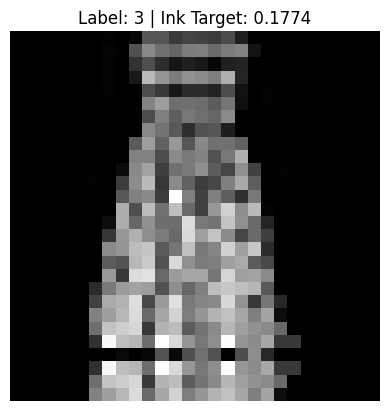

In [28]:
# --- Get one batch from the train_loader ---
try:
    images, labels, inks = next(iter(train_loader))

    # --- Verification ---
    print(f"\n--- Batch Verification ---")
    print(f"Batch 'images' shape: {images.shape}")
    print(f"Batch 'labels' shape: {labels.shape}")
    print(f"Batch 'inks' shape:   {inks.shape}")
    
    print(f"\nBatch 'images' dtype: {images.dtype}")
    print(f"Batch 'labels' dtype: {labels.dtype}")
    print(f"Batch 'inks' dtype:   {inks.dtype}")
    
    print(f"\nExample 'images' mean (normalized): {images[0].mean():.4f}")
    print(f"Example 'labels' value: {labels[0]}")
    print(f"Example 'inks' value (un-normalized mean): {inks[0]:.4f}")

    # --- Plot an example ---
    print("\nPlotting first image in batch...")
    img_to_show = images[0].squeeze().numpy() # Squeeze channel dim
    # De-normalize for plotting
    img_to_show = img_to_show * DATASET_STD + DATASET_MEAN
    
    plt.imshow(img_to_show, cmap='gray')
    plt.title(f"Label: {labels[0]} | Ink Target: {inks[0]:.4f}")
    plt.axis('off')
    plt.show()

except Exception as e:
    print(f"\nError during batch verification: {e}")
    print("Please ensure you have run all previous cells.")

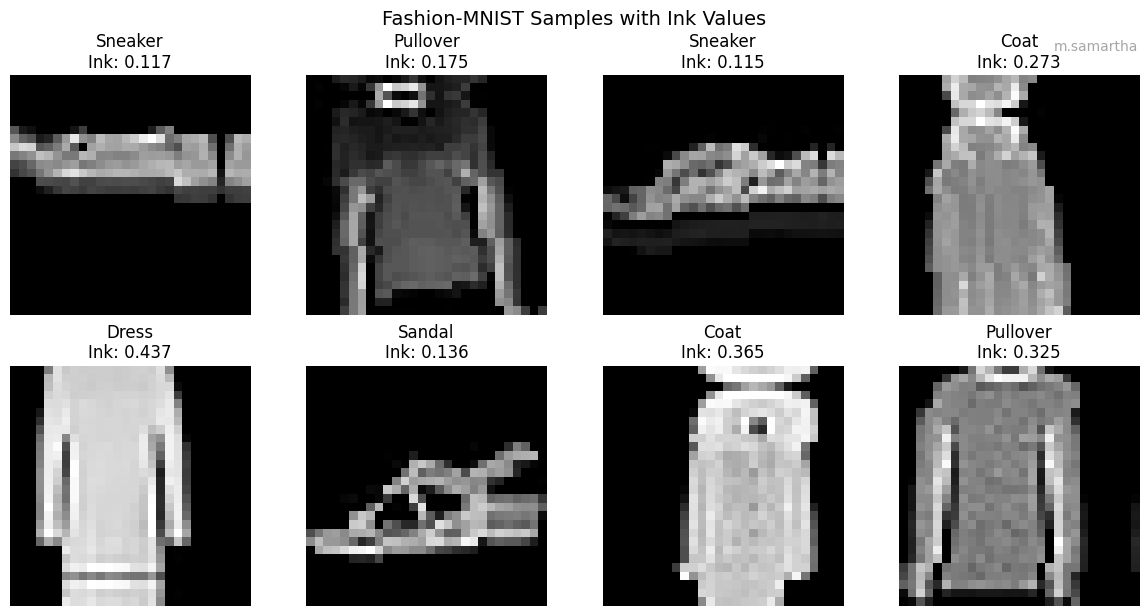

In [29]:
# Visualize some samples from the dataset
def visualize_samples(loader, num_samples=8):
    """
    Visualize samples from the dataset with their labels and ink values.
    """
    dataiter = iter(loader)
    images, labels, ink_values = next(dataiter)
    
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    axes = axes.flatten()
    
    for i in range(min(num_samples, len(images))):
        img = images[i].squeeze()
        # Denormalize for visualization
        img = img * 0.3530 + 0.2860
        img = torch.clamp(img, 0, 1)
        
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f'{class_names[labels[i]]}\nInk: {ink_values[i]:.3f}')
        axes[i].axis('off')
    
    plt.tight_layout()
    add_username_fig(username, fig)
    plt.suptitle('Fashion-MNIST Samples with Ink Values', y=1.02, fontsize=14)
    plt.show()

# Define class names for Fashion-MNIST
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
visualize_samples(train_loader)

## 1.2 Model Implementation: Multi-Task CNN 

### Architecture, Forward pass and Joint loss

In [30]:
class MultiTaskCNN(nn.Module):
    """
    A flexible Multi-Task CNN for Fashion-MNIST.
    The number of blocks and filters can be set at initialization.
    """
    
    def __init__(
        self,
        base_filters: int = 32,
        num_blocks: int = 3,
        dropout_rate: float = 0.25
    ):
        super(MultiTaskCNN, self).__init__()
        
        self.backbone = nn.ModuleList()
        in_channels = 1
        out_channels = base_filters
        current_img_size = 28  # Fashion-MNIST images are 28x28
        
        # --- Create Convolutional Backbone ---
        for i in range(num_blocks):
            self.backbone.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                    nn.BatchNorm2d(out_channels),
                    nn.ReLU(),
                    nn.MaxPool2d(kernel_size=2, stride=2)
                )
            )
            in_channels = out_channels
            out_channels *= 2
            current_img_size //= 2  # Each max-pool halves the size

        # --- Create Classifier and Regressor ---
        # The flattened size depends on the number of blocks
        self.flattened_size = in_channels * current_img_size * current_img_size
        
        self.fc_shared = nn.Sequential(
            nn.Linear(self.flattened_size, 256),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate)
        )
        
        self.classification_head = nn.Linear(256, 10)
        self.regression_head = nn.Linear(256, 1)

    def forward(
        self,
        x: torch.Tensor,
        return_features: bool = False
    ) -> tuple:
        
        fmaps = []
        # Pass through dynamic backbone
        for block in self.backbone:
            x = block(x)
            if return_features:
                fmaps.append(x)
        
        # Flatten
        x_flat = x.view(-1, self.flattened_size)
        
        # Shared layer
        x_shared = self.fc_shared(x_flat)
        
        # Heads
        logits = self.classification_head(x_shared)
        regression_output = self.regression_head(x_shared)
        
        # Squeeze regression output from [B, 1] to [B]
        regression_output = regression_output.squeeze(-1)
        
        if return_features:
            return (logits, regression_output, fmaps)
        else:
            return (logits, regression_output)
    
    def compute_loss(
        self,
        class_logits,
        reg_output,
        class_labels,
        ink_targets,
        lambda1: float = 1.0,
        lambda2: float = 1.0
    ) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Compute the joint loss.
        
        Args:
            class_logits: Classification logits [B, 10]
            reg_output: Regression output [B] (already squeezed)
            class_labels: Ground truth class labels [B]
            ink_targets: Ground truth ink values [B]
            lambda1: Weight for classification loss
            lambda2: Weight for regression loss
            
        Returns:
            total_loss: Combined loss
            ce_loss: Classification loss
            mse_loss: Regression loss
        """
        # Classification loss (Cross-Entropy)
        ce_loss = F.cross_entropy(class_logits, class_labels)
        
        # Regression loss (MSE)
        # No squeeze needed here, as model output is already [B]
        mse_loss = F.mse_loss(reg_output, ink_targets)
        
        # Total loss
        total_loss = lambda1 * ce_loss + lambda2 * mse_loss
        
        return total_loss, ce_loss, mse_loss

In [31]:
# Test the model architecture
model = MultiTaskCNN(dropout_rate=0.3).to(device)
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

MultiTaskCNN(
  (backbone): ModuleList(
    (0): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (fc_shared): Sequential(
    (0): Linear(in_features=115

In [32]:
# Test forward pass
test_input = torch.randn(4, 1, 28, 28).to(device)
class_logits, reg_output = model(test_input)
print(f"\nInput shape: {test_input.shape}")
print(f"Classification output shape: {class_logits.shape}")
print(f"Regression output shape: {reg_output.shape}")

# Compute dummy loss
dummy_labels = torch.tensor([0, 1, 2, 3], dtype=torch.long).to(device)
dummy_inks = torch.tensor([0.1, 0.2, 0.3, 0.4], dtype=torch.float).to(device)
total_loss, ce_loss, mse_loss = model.compute_loss(
    class_logits,
    reg_output,
    dummy_labels,
    dummy_inks
)
print(f"\nTotal loss: {total_loss.item():.4f}")
print(f"Classification loss: {ce_loss.item():.4f}")
print(f"Regression loss: {mse_loss.item():.4f}")


Input shape: torch.Size([4, 1, 28, 28])
Classification output shape: torch.Size([4, 10])
Regression output shape: torch.Size([4])

Total loss: 2.2902
Classification loss: 2.2717
Regression loss: 0.0185


## 1.3 Hyperparameter Tuning and wandb Logging 

In [33]:
# --- Login to Weights & Biases ---
try:
    wandb.login()
except Exception as e:
    print(f"Could not log in to wandb: {e}\n"
          "Please run 'wandb login' in your terminal or a code cell.")

# --- Global Constants ---
device = "cuda" if torch.cuda.is_available() else "cpu"

# These are the pre-calculated values from our previous step
DATASET_MEAN = 0.2861
DATASET_STD = 0.3530

# For visualization
CLASS_NAMES = [
    'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
]

print(f"Using device: {device}")

wandb: Currently logged in as: m-samartha (m-samartha-iiit-hyderabad) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Using device: cuda


### Helper functions for training and evaluation
**calculate_metrics** : This function calculates accuracy for the classification task and MAE, RMSE for the regression task. 

**log_test_visualizations** : Runs inference on 5 test samples and logs the predicted and true labels using wandb.

In [34]:
def calculate_metrics(
    logits_list: torch.Tensor,
    labels_list: torch.Tensor,
    reg_preds_list: torch.Tensor,
    reg_targets_list: torch.Tensor
) -> tuple[float, float, float]:
    """
    Calculates all required metrics from concatenated tensors.
    """
    # --- Classification Metrics ---
    # Get predictions from logits
    class_preds = torch.argmax(logits_list, dim=1)
    accuracy = (class_preds == labels_list).float().mean().item()
    
    # --- Regression Metrics ---
    # Move to CPU/numpy for sklearn
    reg_preds_np = reg_preds_list.cpu().numpy()
    reg_targets_np = reg_targets_list.cpu().numpy()
    
    mae = mean_absolute_error(reg_targets_np, reg_preds_np)
    rmse = np.sqrt(mean_squared_error(reg_targets_np, reg_preds_np))
    
    return accuracy, mae, rmse

def log_test_visualizations(
    model: nn.Module,
    test_dataset: Dataset,
    device: str,
    num_images: int = 5
):
    """
    Selects 5 random images from the test set, runs inference,
    and logs them to wandb.
    """
    model.eval()
    
    # Get 5 random indices
    indices = np.random.choice(len(test_dataset), num_images, replace=False)
    
    wandb_images = []
    
    for idx in indices:
        # Get data (image, label, ink)
        # Note: test_dataset is our CustomDataset, so it returns 3 items
        image, class_label, ink_target = test_dataset[idx]
        
        # Prepare for model
        image_batch = image.unsqueeze(0).to(device) # [1, 1, 28, 28]
        
        # Run inference
        with torch.no_grad():
            logits_out, reg_out = model(image_batch)
        
        # Process outputs
        class_pred = logits_out.argmax(dim=1).item()
        reg_pred = reg_out.item()
        
        # De-normalize image for plotting
        img_np = image.squeeze().cpu().numpy() # [28, 28]
        img_np = (img_np * DATASET_STD) + DATASET_MEAN
        
        # Create plot
        fig, ax = plt.subplots(figsize=(4, 4))
        ax.imshow(img_np, cmap='gray')
        ax.axis('off')
        
        title = (
            f"GT Label: {CLASS_NAMES[class_label]} ({class_label})\n"
            f"Pred Label: {CLASS_NAMES[class_pred]} ({class_pred})\n"
            f"GT Ink: {ink_target:.3f} | Pred Ink: {reg_pred:.3f}"
        )
        ax.set_title(title)
        
        # Add to list for wandb
        wandb_images.append(wandb.Image(fig))
        plt.close(fig) # Close figure to save memory
        
    # Log all 5 images
    wandb.log({"test_visualizations": wandb_images})
    print(f"Logged {num_images} test visualizations to wandb.")

### train_step and eval_step functions

In [35]:
def train_step(
    model: nn.Module,
    loader: DataLoader,
    optimizer: optim.Optimizer,
    device: str,
    lambda1: float,
    lambda2: float
) -> tuple[float, float, float]:
    """Runs one epoch of training."""
    model.train()
    total_loss_epoch, ce_loss_epoch, mse_loss_epoch = 0.0, 0.0, 0.0
    
    for batch in loader:
        images, class_labels, ink_targets = batch
        
        # Move to device
        images = images.to(device)
        class_labels = class_labels.to(device)
        ink_targets = ink_targets.to(device)
        
        # Forward pass
        logits, reg_output = model(images)
        
        # Compute loss
        total_loss, ce_loss, mse_loss = model.compute_loss(
            logits, reg_output, class_labels, ink_targets, lambda1, lambda2
        )
        
        # Backward pass and optimization
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        
        # Accumulate losses
        total_loss_epoch += total_loss.item()
        ce_loss_epoch += ce_loss.item()
        mse_loss_epoch += mse_loss.item()
        
    # Return average losses for the epoch
    num_batches = len(loader)
    return (
        total_loss_epoch / num_batches,
        ce_loss_epoch / num_batches,
        mse_loss_epoch / num_batches
    )


def eval_step(
    model: nn.Module,
    loader: DataLoader,
    device: str,
    lambda1: float,
    lambda2: float
) -> tuple[tuple, tuple]:
    """Runs one epoch of evaluation."""
    model.eval()
    total_loss_epoch, ce_loss_epoch, mse_loss_epoch = 0.0, 0.0, 0.0
    
    # Store all outputs for final metric calculation
    all_logits = []
    all_labels = []
    all_reg_preds = []
    all_reg_targets = []
    
    with torch.no_grad():
        for batch in loader:
            images, class_labels, ink_targets = batch
            
            # Move to device
            images = images.to(device)
            class_labels = class_labels.to(device)
            ink_targets = ink_targets.to(device)
            
            # Forward pass
            logits, reg_output = model(images)
            
            # Compute loss
            total_loss, ce_loss, mse_loss = model.compute_loss(
                logits, reg_output, class_labels, ink_targets, lambda1, lambda2
            )
            
            # Accumulate losses
            total_loss_epoch += total_loss.item()
            ce_loss_epoch += ce_loss.item()
            mse_loss_epoch += mse_loss.item()
            
            # Store outputs
            all_logits.append(logits.cpu())
            all_labels.append(class_labels.cpu())
            all_reg_preds.append(reg_output.cpu())
            all_reg_targets.append(ink_targets.cpu())

    # Calculate average losses
    num_batches = len(loader)
    avg_total_loss = total_loss_epoch / num_batches
    avg_ce_loss = ce_loss_epoch / num_batches
    avg_mse_loss = mse_loss_epoch / num_batches
    
    # Concatenate all stored tensors
    all_logits_cat = torch.cat(all_logits)
    all_labels_cat = torch.cat(all_labels)
    all_reg_preds_cat = torch.cat(all_reg_preds)
    all_reg_targets_cat = torch.cat(all_reg_targets)
    
    # Calculate metrics
    accuracy, mae, rmse = calculate_metrics(
        all_logits_cat, all_labels_cat, all_reg_preds_cat, all_reg_targets_cat
    )
    
    losses = (avg_total_loss, avg_ce_loss, avg_mse_loss)
    metrics = (accuracy, mae, rmse)
    
    return losses, metrics

### Main training loop

In [36]:
def train_model():
    """
    Main training function to be called by wandb.agent.
    """
    # Initialize wandb for this run
    # Config values are automatically pulled from the sweep
    run = wandb.init()
    config = wandb.config
    
    print(f"\n--- Starting Run: {run.name} ---")
    print(f"Config: {config}")

    # --- 1. Setup DataLoaders (using config.batch_size) ---
    # Create DataLoaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=config.batch_size,
        shuffle=True,
        num_workers=4
    )
    val_loader = DataLoader(val_dataset, batch_size=config.batch_size, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=config.batch_size, num_workers=4)
    
    # --- 2. Setup Model (using config) ---
    model = MultiTaskCNN(
        base_filters=config.base_filters,
        num_blocks=config.num_blocks,
        dropout_rate=config.dropout_rate
    ).to(device)
    
    wandb.watch(model, log='all', log_freq=100)
    
    # --- 3. Setup Optimizer (using config) ---
    if config.optimizer == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)
    elif config.optimizer == 'adamw':
        optimizer = optim.AdamW(model.parameters(), lr=config.learning_rate)
    else: # sgd
        optimizer = optim.SGD(
            model.parameters(),
            lr=config.learning_rate,
            momentum=0.9
        )
        
    # --- 4. Training Loop ---
    print("Starting training...")
    for epoch in range(config.epochs):
        # Training
        train_total_loss, train_ce, train_mse = train_step(
            model, train_loader, optimizer, device,
            config.lambda_pair['lambda1'], config.lambda_pair['lambda2']
        )
        
        # Validation
        (val_total_loss, val_ce, val_mse), (val_acc, val_mae, val_rmse) = eval_step(
            model, val_loader, device, config.lambda_pair['lambda1'], config.lambda_pair['lambda2']
        )
        
        # Log metrics to wandb
        wandb.log({
            "epoch": epoch,
            "train/total_loss": train_total_loss,
            "train/ce_loss": train_ce,
            "train/mse_loss": train_mse,
            "validation/total_loss": val_total_loss,
            "validation/ce_loss": val_ce,
            "validation/mse_loss": val_mse,
            "validation/accuracy": val_acc,
            "validation/mae": val_mae,
            "validation/rmse": val_rmse
        })

        print(f"Epoch {epoch+1:02d} | "
                f"Val Loss: {val_total_loss:.4f} | "
                f"Val Acc: {val_acc:.4f} | "
                f"Val RMSE: {val_rmse:.4f}")

    print("Training finished.")
    
    # --- 5. Final Test Evaluation ---
    print("Running final test evaluation...")
    (test_total_loss, test_ce, test_mse), (test_acc, test_mae, test_rmse) = eval_step(
        model, test_loader, device, config.lambda_pair['lambda1'], config.lambda_pair['lambda2']
    )
    
    # Log final test metrics
    wandb.log({
        "test/total_loss": test_total_loss,
        "test/ce_loss": test_ce,
        "test/mse_loss": test_mse,
        "test/accuracy": test_acc,
        "test/mae": test_mae,
        "test/rmse": test_rmse
    })
    print(f"Test Results: Acc: {test_acc:.4f}, RMSE: {test_rmse:.4f}")
    
    # --- 6. Log Visualizations ---
    print("Logging test visualizations...")
    log_test_visualizations(model, test_dataset, device, num_images=5)
    
    # --- 7. Finish Run ---
    run.finish()

### Hyperparameters 

In [24]:
sweep_config = {
    'method': 'bayes',  # Use Bayesian optimization
    'metric': {
      'name': 'validation/accuracy',  # Metric to optimize
      'goal': 'maximize'   # We want to maximize accuracy
    },
    'parameters': {
        'epochs': {
            'value': 25  # Fixed number of epochs for all runs
        },
        'learning_rate': {
            'distribution': 'log_uniform_values',
            'min': 1e-4,
            'max': 1e-2
        },
        'dropout_rate': {
            'values': [0.2, 0.3, 0.4]
        },
        'optimizer': {
            'values': ['adam', 'adamw', 'sgd']
        },
        'num_blocks': {
            'values': [2, 3]  # 2 or 3 conv blocks
        },
        'base_filters': {
            'values': [16, 32]  # Starting number of filters
        },
        'batch_size': {
            'values': [32, 64, 128]
        },
        'lambda_pair': {
            'values': [
                {'lambda1': 0.45, 'lambda2': 1.34},
                {'lambda1': 0.75, 'lambda2': 1.20},
                {'lambda1': 1.0, 'lambda2': 1.0},
                {'lambda1': 1.20, 'lambda2': 0.75},
                {'lambda1': 1.34, 'lambda2': 0.45}
            ]
        }
    }
}

### Training runs 

In [ ]:
# 1. Initialize the Sweep
sweep_id = wandb.sweep(
    sweep=sweep_config,
    project="2023102038-A4-Q1"
)

print(f"Sweep initialized. ID: {sweep_id}")

# 2. Run the Agent
# This will run 5 trials from the sweep, one after another.
# You can also run this from your terminal.
print("\nStarting wandb agent to run 5 trials...")
try:
    wandb.agent(
        sweep_id,
        function=train_model,
        count=25  # Conduct 25 distinct runs
    )
    print("Sweep finished.")
except Exception as e:
    print(f"An error occurred during the sweep: {e}")

Create sweep with ID: xlby83d8
Sweep URL: https://wandb.ai/m-samartha-iiit-hyderabad/2023102038-A4-Q1/sweeps/xlby83d8
Sweep initialized. ID: xlby83d8

Starting wandb agent to run 5 trials...


wandb: Agent Starting Run: bcgyomec with config:
wandb: 	base_filters: 32
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0.4
wandb: 	epochs: 25
wandb: 	lambda_pair: {'lambda1': 0.45, 'lambda2': 1.34}
wandb: 	learning_rate: 0.00045477917677642904
wandb: 	num_blocks: 2
wandb: 	optimizer: sgd



--- Starting Run: glad-sweep-1 ---
Config: {'base_filters': 32, 'batch_size': 128, 'dropout_rate': 0.4, 'epochs': 25, 'lambda_pair': {'lambda1': 0.45, 'lambda2': 1.34}, 'learning_rate': 0.00045477917677642904, 'num_blocks': 2, 'optimizer': 'sgd'}
Starting training...
Epoch 01 | Val Loss: 0.4445 | Val Acc: 0.7012 | Val RMSE: 0.0403
Epoch 02 | Val Loss: 0.3507 | Val Acc: 0.7347 | Val RMSE: 0.0362
Epoch 03 | Val Loss: 0.3166 | Val Acc: 0.7525 | Val RMSE: 0.0321
Epoch 04 | Val Loss: 0.2986 | Val Acc: 0.7618 | Val RMSE: 0.0306
Epoch 05 | Val Loss: 0.2863 | Val Acc: 0.7687 | Val RMSE: 0.0293
Epoch 06 | Val Loss: 0.2771 | Val Acc: 0.7743 | Val RMSE: 0.0282
Epoch 07 | Val Loss: 0.2689 | Val Acc: 0.7838 | Val RMSE: 0.0282
Epoch 08 | Val Loss: 0.2638 | Val Acc: 0.7868 | Val RMSE: 0.0278
Epoch 09 | Val Loss: 0.2583 | Val Acc: 0.7940 | Val RMSE: 0.0338
Epoch 10 | Val Loss: 0.2515 | Val Acc: 0.7945 | Val RMSE: 0.0258
Epoch 11 | Val Loss: 0.2469 | Val Acc: 0.8017 | Val RMSE: 0.0261
Epoch 12 | Val L

epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
test/accuracy,▁
test/ce_loss,▁
test/mae,▁
test/mse_loss,▁
test/rmse,▁
test/total_loss,▁
train/ce_loss,█▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
train/mse_loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/total_loss,█▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
+6,...


wandb: Agent Starting Run: 9advphfu with config:
wandb: 	base_filters: 16
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 25
wandb: 	lambda_pair: {'lambda1': 0.75, 'lambda2': 1.2}
wandb: 	learning_rate: 0.00010280223193232828
wandb: 	num_blocks: 2
wandb: 	optimizer: adam



--- Starting Run: grateful-sweep-2 ---
Config: {'base_filters': 16, 'batch_size': 32, 'dropout_rate': 0.3, 'epochs': 25, 'lambda_pair': {'lambda1': 0.75, 'lambda2': 1.2}, 'learning_rate': 0.00010280223193232828, 'num_blocks': 2, 'optimizer': 'adam'}
Starting training...
Epoch 01 | Val Loss: 0.4222 | Val Acc: 0.7883 | Val RMSE: 0.0377
Epoch 02 | Val Loss: 0.3480 | Val Acc: 0.8318 | Val RMSE: 0.0299
Epoch 03 | Val Loss: 0.3403 | Val Acc: 0.8398 | Val RMSE: 0.0323
Epoch 04 | Val Loss: 0.3069 | Val Acc: 0.8505 | Val RMSE: 0.0328
Epoch 05 | Val Loss: 0.2998 | Val Acc: 0.8520 | Val RMSE: 0.0334
Epoch 06 | Val Loss: 0.2820 | Val Acc: 0.8612 | Val RMSE: 0.0294
Epoch 07 | Val Loss: 0.2736 | Val Acc: 0.8663 | Val RMSE: 0.0268
Epoch 08 | Val Loss: 0.2652 | Val Acc: 0.8682 | Val RMSE: 0.0295
Epoch 09 | Val Loss: 0.2622 | Val Acc: 0.8710 | Val RMSE: 0.0276
Epoch 10 | Val Loss: 0.2566 | Val Acc: 0.8757 | Val RMSE: 0.0313
Epoch 11 | Val Loss: 0.2636 | Val Acc: 0.8645 | Val RMSE: 0.0322
Epoch 12 | Va

epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
test/accuracy,▁
test/ce_loss,▁
test/mae,▁
test/mse_loss,▁
test/rmse,▁
test/total_loss,▁
train/ce_loss,█▅▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
train/mse_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/total_loss,█▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
+6,...


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: bvlsbq8v with config:
wandb: 	base_filters: 16
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 25
wandb: 	lambda_pair: {'lambda1': 1.34, 'lambda2': 0.45}
wandb: 	learning_rate: 0.00022184049157380489
wandb: 	num_blocks: 3
wandb: 	optimizer: sgd



--- Starting Run: woven-sweep-3 ---
Config: {'base_filters': 16, 'batch_size': 64, 'dropout_rate': 0.3, 'epochs': 25, 'lambda_pair': {'lambda1': 1.34, 'lambda2': 0.45}, 'learning_rate': 0.00022184049157380489, 'num_blocks': 3, 'optimizer': 'sgd'}
Starting training...
Epoch 01 | Val Loss: 1.1163 | Val Acc: 0.7243 | Val RMSE: 0.0726
Epoch 02 | Val Loss: 0.9076 | Val Acc: 0.7485 | Val RMSE: 0.0592
Epoch 03 | Val Loss: 0.8227 | Val Acc: 0.7688 | Val RMSE: 0.0509
Epoch 04 | Val Loss: 0.7677 | Val Acc: 0.7847 | Val RMSE: 0.0490
Epoch 05 | Val Loss: 0.7196 | Val Acc: 0.7983 | Val RMSE: 0.0430
Epoch 06 | Val Loss: 0.6873 | Val Acc: 0.8102 | Val RMSE: 0.0442
Epoch 07 | Val Loss: 0.6710 | Val Acc: 0.8193 | Val RMSE: 0.0437
Epoch 08 | Val Loss: 0.6380 | Val Acc: 0.8275 | Val RMSE: 0.0424
Epoch 09 | Val Loss: 0.6114 | Val Acc: 0.8353 | Val RMSE: 0.0430
Epoch 10 | Val Loss: 0.5908 | Val Acc: 0.8388 | Val RMSE: 0.0433
Epoch 11 | Val Loss: 0.5702 | Val Acc: 0.8465 | Val RMSE: 0.0446
Epoch 12 | Val L

epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
test/accuracy,▁
test/ce_loss,▁
test/mae,▁
test/mse_loss,▁
test/rmse,▁
test/total_loss,▁
train/ce_loss,█▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
train/mse_loss,█▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/total_loss,█▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
+6,...


wandb: Agent Starting Run: kix52dea with config:
wandb: 	base_filters: 16
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 25
wandb: 	lambda_pair: {'lambda1': 0.75, 'lambda2': 1.2}
wandb: 	learning_rate: 0.005876893342696664
wandb: 	num_blocks: 3
wandb: 	optimizer: adam



--- Starting Run: sleek-sweep-4 ---
Config: {'base_filters': 16, 'batch_size': 128, 'dropout_rate': 0.2, 'epochs': 25, 'lambda_pair': {'lambda1': 0.75, 'lambda2': 1.2}, 'learning_rate': 0.005876893342696664, 'num_blocks': 3, 'optimizer': 'adam'}
Starting training...
Epoch 01 | Val Loss: 0.4821 | Val Acc: 0.7538 | Val RMSE: 0.0638
Epoch 02 | Val Loss: 0.4352 | Val Acc: 0.7758 | Val RMSE: 0.0649
Epoch 03 | Val Loss: 0.4122 | Val Acc: 0.7990 | Val RMSE: 0.0880
Epoch 04 | Val Loss: 0.3470 | Val Acc: 0.8387 | Val RMSE: 0.0920
Epoch 05 | Val Loss: 0.3338 | Val Acc: 0.8487 | Val RMSE: 0.0898
Epoch 06 | Val Loss: 0.3358 | Val Acc: 0.8433 | Val RMSE: 0.0810
Epoch 07 | Val Loss: 0.2997 | Val Acc: 0.8647 | Val RMSE: 0.0836
Epoch 08 | Val Loss: 0.2971 | Val Acc: 0.8623 | Val RMSE: 0.0883
Epoch 09 | Val Loss: 0.2928 | Val Acc: 0.8575 | Val RMSE: 0.0921
Epoch 10 | Val Loss: 0.2867 | Val Acc: 0.8718 | Val RMSE: 0.0909
Epoch 11 | Val Loss: 0.2694 | Val Acc: 0.8717 | Val RMSE: 0.0896
Epoch 12 | Val Lo

wandb: Ctrl + C detected. Stopping sweep.


Sweep finished.


wandb: ERROR Problem finishing run
Traceback (most recent call last):
  File "/home/mpsamartha/miniconda3/envs/smai-conda/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 297, in _run_job
    self._function()
  File "/tmp/ipykernel_78481/1748046284.py", line 102, in train_model
    run.finish()
  File "/home/mpsamartha/miniconda3/envs/smai-conda/lib/python3.10/site-packages/wandb/sdk/wandb_run.py", line 399, in wrapper
    return func(self, *args, **kwargs)
  File "/home/mpsamartha/miniconda3/envs/smai-conda/lib/python3.10/site-packages/wandb/sdk/wandb_run.py", line 444, in wrapper
    return func(self, *args, **kwargs)
  File "/home/mpsamartha/miniconda3/envs/smai-conda/lib/python3.10/site-packages/wandb/sdk/wandb_run.py", line 2263, in finish
    return self._finish(exit_code)
  File "/home/mpsamartha/miniconda3/envs/smai-conda/lib/python3.10/site-packages/wandb/sdk/wandb_run.py", line 399, in wrapper
    return func(self, *args, **kwargs)
  File "/home/mpsamartha/minicond

In [ ]:
sweep_id = "xlby83d8"  # your sweep ID
print(f"Sweep ID: {sweep_id}")
print("Starting agent...")

# Run the Agent (this will execute 'run_sweep_iteration' for remaining 22 times)
wandb.agent(sweep_id, function=train_model, count=22)

print("Sweep complete!")

Sweep ID: xlby83d8
Starting agent...


wandb: ERROR Run 1t8lshgb errored:
wandb: ERROR Traceback (most recent call last):
wandb: ERROR   File "/home/mpsamartha/miniconda3/envs/smai-conda/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 290, in _run_job
wandb: ERROR     wandb.teardown()
wandb: ERROR   File "/home/mpsamartha/miniconda3/envs/smai-conda/lib/python3.10/contextlib.py", line 79, in inner
wandb: ERROR     return func(*args, **kwds)
wandb: ERROR   File "/home/mpsamartha/miniconda3/envs/smai-conda/lib/python3.10/site-packages/wandb/sdk/wandb_setup.py", line 560, in teardown
wandb: ERROR     orig_singleton._teardown(exit_code=exit_code)
wandb: ERROR   File "/home/mpsamartha/miniconda3/envs/smai-conda/lib/python3.10/site-packages/wandb/sdk/wandb_setup.py", line 385, in _teardown
wandb: ERROR     internal_exit_code = self._connection.teardown(exit_code or 0)
wandb: ERROR   File "/home/mpsamartha/miniconda3/envs/smai-conda/lib/python3.10/site-packages/wandb/sdk/lib/service/service_connection.py", line 236, in 


--- Starting Run: leafy-sweep-6 ---
Config: {'base_filters': 16, 'batch_size': 128, 'dropout_rate': 0.4, 'epochs': 25, 'lambda_pair': {'lambda1': 1.34, 'lambda2': 0.45}, 'learning_rate': 0.0008343244118526257, 'num_blocks': 2, 'optimizer': 'sgd'}
Starting training...
Epoch 01 | Val Loss: 0.9345 | Val Acc: 0.7467 | Val RMSE: 0.0528
Epoch 02 | Val Loss: 0.7960 | Val Acc: 0.7802 | Val RMSE: 0.0437
Epoch 03 | Val Loss: 0.7409 | Val Acc: 0.7942 | Val RMSE: 0.0517
Epoch 04 | Val Loss: 0.6949 | Val Acc: 0.8050 | Val RMSE: 0.0434
Epoch 05 | Val Loss: 0.6634 | Val Acc: 0.8160 | Val RMSE: 0.0479
Epoch 06 | Val Loss: 0.6341 | Val Acc: 0.8262 | Val RMSE: 0.0439
Epoch 07 | Val Loss: 0.6055 | Val Acc: 0.8372 | Val RMSE: 0.0420
Epoch 08 | Val Loss: 0.5928 | Val Acc: 0.8405 | Val RMSE: 0.0391
Epoch 09 | Val Loss: 0.5669 | Val Acc: 0.8493 | Val RMSE: 0.0415
Epoch 10 | Val Loss: 0.5549 | Val Acc: 0.8488 | Val RMSE: 0.0418
Epoch 11 | Val Loss: 0.5334 | Val Acc: 0.8552 | Val RMSE: 0.0406
Epoch 12 | Val L

epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
test/accuracy,▁
test/ce_loss,▁
test/mae,▁
test/mse_loss,▁
test/rmse,▁
test/total_loss,▁
train/ce_loss,█▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
train/mse_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/total_loss,█▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
+6,...


wandb: Agent Starting Run: ilrku28g with config:
wandb: 	base_filters: 32
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 25
wandb: 	lambda_pair: {'lambda1': 1, 'lambda2': 1}
wandb: 	learning_rate: 0.00014017114137858803
wandb: 	num_blocks: 3
wandb: 	optimizer: adam



--- Starting Run: peachy-sweep-7 ---
Config: {'base_filters': 32, 'batch_size': 64, 'dropout_rate': 0.3, 'epochs': 25, 'lambda_pair': {'lambda1': 1, 'lambda2': 1}, 'learning_rate': 0.00014017114137858803, 'num_blocks': 3, 'optimizer': 'adam'}
Starting training...
Epoch 01 | Val Loss: 0.4953 | Val Acc: 0.8113 | Val RMSE: 0.0427
Epoch 02 | Val Loss: 0.4160 | Val Acc: 0.8508 | Val RMSE: 0.0369
Epoch 03 | Val Loss: 0.3633 | Val Acc: 0.8655 | Val RMSE: 0.0389
Epoch 04 | Val Loss: 0.3282 | Val Acc: 0.8813 | Val RMSE: 0.0337
Epoch 05 | Val Loss: 0.3138 | Val Acc: 0.8812 | Val RMSE: 0.0348
Epoch 06 | Val Loss: 0.3263 | Val Acc: 0.8758 | Val RMSE: 0.0326
Epoch 07 | Val Loss: 0.3500 | Val Acc: 0.8678 | Val RMSE: 0.0307
Epoch 08 | Val Loss: 0.3029 | Val Acc: 0.8880 | Val RMSE: 0.0263
Epoch 09 | Val Loss: 0.2804 | Val Acc: 0.8952 | Val RMSE: 0.0287
Epoch 10 | Val Loss: 0.2740 | Val Acc: 0.8968 | Val RMSE: 0.0303
Epoch 11 | Val Loss: 0.2962 | Val Acc: 0.8872 | Val RMSE: 0.0265
Epoch 12 | Val Loss:

epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
test/accuracy,▁
test/ce_loss,▁
test/mae,▁
test/mse_loss,▁
test/rmse,▁
test/total_loss,▁
train/ce_loss,█▄▄▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
train/mse_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/total_loss,█▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
+6,...


wandb: Agent Starting Run: nijnse6p with config:
wandb: 	base_filters: 32
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 25
wandb: 	lambda_pair: {'lambda1': 1.2, 'lambda2': 0.75}
wandb: 	learning_rate: 0.0004214600873098379
wandb: 	num_blocks: 3
wandb: 	optimizer: adamw



--- Starting Run: honest-sweep-8 ---
Config: {'base_filters': 32, 'batch_size': 128, 'dropout_rate': 0.3, 'epochs': 25, 'lambda_pair': {'lambda1': 1.2, 'lambda2': 0.75}, 'learning_rate': 0.0004214600873098379, 'num_blocks': 3, 'optimizer': 'adamw'}
Starting training...
Epoch 01 | Val Loss: 0.5703 | Val Acc: 0.8273 | Val RMSE: 0.0663
Epoch 02 | Val Loss: 0.4526 | Val Acc: 0.8603 | Val RMSE: 0.0452
Epoch 03 | Val Loss: 0.4417 | Val Acc: 0.8590 | Val RMSE: 0.0412
Epoch 04 | Val Loss: 0.3822 | Val Acc: 0.8797 | Val RMSE: 0.0496
Epoch 05 | Val Loss: 0.3872 | Val Acc: 0.8807 | Val RMSE: 0.0411
Epoch 06 | Val Loss: 0.3510 | Val Acc: 0.8892 | Val RMSE: 0.0431
Epoch 07 | Val Loss: 0.3645 | Val Acc: 0.8857 | Val RMSE: 0.0379
Epoch 08 | Val Loss: 0.3505 | Val Acc: 0.8910 | Val RMSE: 0.0400
Epoch 09 | Val Loss: 0.3197 | Val Acc: 0.8980 | Val RMSE: 0.0421
Epoch 10 | Val Loss: 0.3184 | Val Acc: 0.8993 | Val RMSE: 0.0326
Epoch 11 | Val Loss: 0.3694 | Val Acc: 0.8875 | Val RMSE: 0.0315
Epoch 12 | Val

epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
test/accuracy,▁
test/ce_loss,▁
test/mae,▁
test/mse_loss,▁
test/rmse,▁
test/total_loss,▁
train/ce_loss,█▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
train/mse_loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/total_loss,█▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
+6,...


wandb: Agent Starting Run: dcyjangk with config:
wandb: 	base_filters: 32
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.4
wandb: 	epochs: 25
wandb: 	lambda_pair: {'lambda1': 1.34, 'lambda2': 0.45}
wandb: 	learning_rate: 0.0001926408929676702
wandb: 	num_blocks: 3
wandb: 	optimizer: adam



--- Starting Run: woven-sweep-9 ---
Config: {'base_filters': 32, 'batch_size': 64, 'dropout_rate': 0.4, 'epochs': 25, 'lambda_pair': {'lambda1': 1.34, 'lambda2': 0.45}, 'learning_rate': 0.0001926408929676702, 'num_blocks': 3, 'optimizer': 'adam'}
Starting training...
Epoch 01 | Val Loss: 0.6372 | Val Acc: 0.8237 | Val RMSE: 0.0482
Epoch 02 | Val Loss: 0.5280 | Val Acc: 0.8563 | Val RMSE: 0.0593
Epoch 03 | Val Loss: 0.4762 | Val Acc: 0.8688 | Val RMSE: 0.0527
Epoch 04 | Val Loss: 0.4508 | Val Acc: 0.8783 | Val RMSE: 0.0487
Epoch 05 | Val Loss: 0.4152 | Val Acc: 0.8867 | Val RMSE: 0.0459
Epoch 06 | Val Loss: 0.4263 | Val Acc: 0.8818 | Val RMSE: 0.0540
Epoch 07 | Val Loss: 0.3941 | Val Acc: 0.8905 | Val RMSE: 0.0466
Epoch 08 | Val Loss: 0.4126 | Val Acc: 0.8830 | Val RMSE: 0.0525
Epoch 09 | Val Loss: 0.3789 | Val Acc: 0.8907 | Val RMSE: 0.0445
Epoch 10 | Val Loss: 0.3736 | Val Acc: 0.8927 | Val RMSE: 0.0507
Epoch 11 | Val Loss: 0.3721 | Val Acc: 0.8957 | Val RMSE: 0.0418
Epoch 12 | Val L

epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
test/accuracy,▁
test/ce_loss,▁
test/mae,▁
test/mse_loss,▁
test/rmse,▁
test/total_loss,▁
train/ce_loss,█▄▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
train/mse_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/total_loss,█▄▄▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
+6,...


wandb: Agent Starting Run: 3325mxd2 with config:
wandb: 	base_filters: 32
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 25
wandb: 	lambda_pair: {'lambda1': 1.2, 'lambda2': 0.75}
wandb: 	learning_rate: 0.00016241091405548363
wandb: 	num_blocks: 3
wandb: 	optimizer: adam



--- Starting Run: rare-sweep-10 ---
Config: {'base_filters': 32, 'batch_size': 128, 'dropout_rate': 0.3, 'epochs': 25, 'lambda_pair': {'lambda1': 1.2, 'lambda2': 0.75}, 'learning_rate': 0.00016241091405548363, 'num_blocks': 3, 'optimizer': 'adam'}
Starting training...
Epoch 01 | Val Loss: 0.6378 | Val Acc: 0.8102 | Val RMSE: 0.0666
Epoch 02 | Val Loss: 0.5122 | Val Acc: 0.8435 | Val RMSE: 0.0430
Epoch 03 | Val Loss: 0.4782 | Val Acc: 0.8528 | Val RMSE: 0.0345
Epoch 04 | Val Loss: 0.4266 | Val Acc: 0.8655 | Val RMSE: 0.0351
Epoch 05 | Val Loss: 0.4738 | Val Acc: 0.8528 | Val RMSE: 0.0369
Epoch 06 | Val Loss: 0.3849 | Val Acc: 0.8795 | Val RMSE: 0.0335
Epoch 07 | Val Loss: 0.3915 | Val Acc: 0.8788 | Val RMSE: 0.0343
Epoch 08 | Val Loss: 0.3780 | Val Acc: 0.8825 | Val RMSE: 0.0341
Epoch 09 | Val Loss: 0.3497 | Val Acc: 0.8867 | Val RMSE: 0.0291
Epoch 10 | Val Loss: 0.3440 | Val Acc: 0.8892 | Val RMSE: 0.0324
Epoch 11 | Val Loss: 0.3409 | Val Acc: 0.8873 | Val RMSE: 0.0288
Epoch 12 | Val 

epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
test/accuracy,▁
test/ce_loss,▁
test/mae,▁
test/mse_loss,▁
test/rmse,▁
test/total_loss,▁
train/ce_loss,█▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
train/mse_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/total_loss,█▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
+6,...


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: dv4m8g2e with config:
wandb: 	base_filters: 32
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 25
wandb: 	lambda_pair: {'lambda1': 1.34, 'lambda2': 0.45}
wandb: 	learning_rate: 0.00032213951010437436
wandb: 	num_blocks: 3
wandb: 	optimizer: adam



--- Starting Run: wandering-sweep-11 ---
Config: {'base_filters': 32, 'batch_size': 128, 'dropout_rate': 0.3, 'epochs': 25, 'lambda_pair': {'lambda1': 1.34, 'lambda2': 0.45}, 'learning_rate': 0.00032213951010437436, 'num_blocks': 3, 'optimizer': 'adam'}
Starting training...
Epoch 01 | Val Loss: 0.6022 | Val Acc: 0.8378 | Val RMSE: 0.0532
Epoch 02 | Val Loss: 0.5289 | Val Acc: 0.8567 | Val RMSE: 0.0428
Epoch 03 | Val Loss: 0.4952 | Val Acc: 0.8638 | Val RMSE: 0.0411
Epoch 04 | Val Loss: 0.4592 | Val Acc: 0.8725 | Val RMSE: 0.0367
Epoch 05 | Val Loss: 0.4271 | Val Acc: 0.8787 | Val RMSE: 0.0383
Epoch 06 | Val Loss: 0.4131 | Val Acc: 0.8843 | Val RMSE: 0.0407
Epoch 07 | Val Loss: 0.4176 | Val Acc: 0.8837 | Val RMSE: 0.0415
Epoch 08 | Val Loss: 0.3959 | Val Acc: 0.8867 | Val RMSE: 0.0454
Epoch 09 | Val Loss: 0.3672 | Val Acc: 0.8982 | Val RMSE: 0.0346
Epoch 10 | Val Loss: 0.3635 | Val Acc: 0.8992 | Val RMSE: 0.0433
Epoch 11 | Val Loss: 0.3608 | Val Acc: 0.8990 | Val RMSE: 0.0384
Epoch 12 

epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
test/accuracy,▁
test/ce_loss,▁
test/mae,▁
test/mse_loss,▁
test/rmse,▁
test/total_loss,▁
train/ce_loss,█▅▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
train/mse_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/total_loss,█▄▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
+6,...


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: st7obgrs with config:
wandb: 	base_filters: 32
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 25
wandb: 	lambda_pair: {'lambda1': 1.2, 'lambda2': 0.75}
wandb: 	learning_rate: 0.0002155041856095481
wandb: 	num_blocks: 3
wandb: 	optimizer: adam



--- Starting Run: dry-sweep-12 ---
Config: {'base_filters': 32, 'batch_size': 32, 'dropout_rate': 0.3, 'epochs': 25, 'lambda_pair': {'lambda1': 1.2, 'lambda2': 0.75}, 'learning_rate': 0.0002155041856095481, 'num_blocks': 3, 'optimizer': 'adam'}
Starting training...
Epoch 01 | Val Loss: 0.5311 | Val Acc: 0.8380 | Val RMSE: 0.0526
Epoch 02 | Val Loss: 0.4653 | Val Acc: 0.8645 | Val RMSE: 0.0495
Epoch 03 | Val Loss: 0.3959 | Val Acc: 0.8753 | Val RMSE: 0.0339
Epoch 04 | Val Loss: 0.3783 | Val Acc: 0.8840 | Val RMSE: 0.0403
Epoch 05 | Val Loss: 0.3939 | Val Acc: 0.8783 | Val RMSE: 0.0465
Epoch 06 | Val Loss: 0.3573 | Val Acc: 0.8857 | Val RMSE: 0.0381
Epoch 07 | Val Loss: 0.3785 | Val Acc: 0.8810 | Val RMSE: 0.0337
Epoch 08 | Val Loss: 0.3262 | Val Acc: 0.8990 | Val RMSE: 0.0310
Epoch 09 | Val Loss: 0.3398 | Val Acc: 0.8888 | Val RMSE: 0.0407
Epoch 10 | Val Loss: 0.3113 | Val Acc: 0.9007 | Val RMSE: 0.0357
Epoch 11 | Val Loss: 0.3072 | Val Acc: 0.9045 | Val RMSE: 0.0373
Epoch 12 | Val Los

epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
test/accuracy,▁
test/ce_loss,▁
test/mae,▁
test/mse_loss,▁
test/rmse,▁
test/total_loss,▁
train/ce_loss,█▅▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
train/mse_loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/total_loss,█▄▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
+6,...


wandb: Agent Starting Run: 4c90bzam with config:
wandb: 	base_filters: 32
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.4
wandb: 	epochs: 25
wandb: 	lambda_pair: {'lambda1': 1.2, 'lambda2': 0.75}
wandb: 	learning_rate: 0.0001173133006237186
wandb: 	num_blocks: 3
wandb: 	optimizer: adam



--- Starting Run: likely-sweep-13 ---
Config: {'base_filters': 32, 'batch_size': 32, 'dropout_rate': 0.4, 'epochs': 25, 'lambda_pair': {'lambda1': 1.2, 'lambda2': 0.75}, 'learning_rate': 0.0001173133006237186, 'num_blocks': 3, 'optimizer': 'adam'}
Starting training...
Epoch 01 | Val Loss: 0.5808 | Val Acc: 0.8230 | Val RMSE: 0.0461
Epoch 02 | Val Loss: 0.4736 | Val Acc: 0.8537 | Val RMSE: 0.0423
Epoch 03 | Val Loss: 0.4384 | Val Acc: 0.8647 | Val RMSE: 0.0436
Epoch 04 | Val Loss: 0.4019 | Val Acc: 0.8752 | Val RMSE: 0.0448
Epoch 05 | Val Loss: 0.3858 | Val Acc: 0.8777 | Val RMSE: 0.0415
Epoch 06 | Val Loss: 0.3754 | Val Acc: 0.8835 | Val RMSE: 0.0433
Epoch 07 | Val Loss: 0.3695 | Val Acc: 0.8828 | Val RMSE: 0.0430
Epoch 08 | Val Loss: 0.3574 | Val Acc: 0.8865 | Val RMSE: 0.0414
Epoch 09 | Val Loss: 0.3508 | Val Acc: 0.8907 | Val RMSE: 0.0430
Epoch 10 | Val Loss: 0.3724 | Val Acc: 0.8872 | Val RMSE: 0.0373
Epoch 11 | Val Loss: 0.3507 | Val Acc: 0.8907 | Val RMSE: 0.0390
Epoch 12 | Val 

epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
test/accuracy,▁
test/ce_loss,▁
test/mae,▁
test/mse_loss,▁
test/rmse,▁
test/total_loss,▁
train/ce_loss,█▄▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
train/mse_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/total_loss,█▄▄▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
+6,...


wandb: Agent Starting Run: s1r7sblz with config:
wandb: 	base_filters: 32
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 25
wandb: 	lambda_pair: {'lambda1': 1.2, 'lambda2': 0.75}
wandb: 	learning_rate: 0.0001730161230299981
wandb: 	num_blocks: 3
wandb: 	optimizer: adam



--- Starting Run: hardy-sweep-13 ---
Config: {'base_filters': 32, 'batch_size': 64, 'dropout_rate': 0.2, 'epochs': 25, 'lambda_pair': {'lambda1': 1.2, 'lambda2': 0.75}, 'learning_rate': 0.0001730161230299981, 'num_blocks': 3, 'optimizer': 'adam'}
Starting training...
Epoch 01 | Val Loss: 0.5836 | Val Acc: 0.8252 | Val RMSE: 0.0586
Epoch 02 | Val Loss: 0.4960 | Val Acc: 0.8510 | Val RMSE: 0.0359
Epoch 03 | Val Loss: 0.4311 | Val Acc: 0.8675 | Val RMSE: 0.0347
Epoch 04 | Val Loss: 0.3996 | Val Acc: 0.8755 | Val RMSE: 0.0354
Epoch 05 | Val Loss: 0.3638 | Val Acc: 0.8897 | Val RMSE: 0.0301
Epoch 06 | Val Loss: 0.3624 | Val Acc: 0.8913 | Val RMSE: 0.0331
Epoch 07 | Val Loss: 0.3676 | Val Acc: 0.8842 | Val RMSE: 0.0358
Epoch 08 | Val Loss: 0.3351 | Val Acc: 0.8972 | Val RMSE: 0.0297
Epoch 09 | Val Loss: 0.3358 | Val Acc: 0.8963 | Val RMSE: 0.0330
Epoch 10 | Val Loss: 0.3315 | Val Acc: 0.8980 | Val RMSE: 0.0286
Epoch 11 | Val Loss: 0.3187 | Val Acc: 0.9022 | Val RMSE: 0.0299
Epoch 12 | Val L

epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
test/accuracy,▁
test/ce_loss,▁
test/mae,▁
test/mse_loss,▁
test/rmse,▁
test/total_loss,▁
train/ce_loss,█▄▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
train/mse_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/total_loss,█▄▄▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
+6,...


wandb: Agent Starting Run: ma930gmx with config:
wandb: 	base_filters: 32
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 25
wandb: 	lambda_pair: {'lambda1': 1, 'lambda2': 1}
wandb: 	learning_rate: 0.0001925264245069969
wandb: 	num_blocks: 3
wandb: 	optimizer: adam



--- Starting Run: good-sweep-14 ---
Config: {'base_filters': 32, 'batch_size': 32, 'dropout_rate': 0.2, 'epochs': 25, 'lambda_pair': {'lambda1': 1, 'lambda2': 1}, 'learning_rate': 0.0001925264245069969, 'num_blocks': 3, 'optimizer': 'adam'}
Starting training...
Epoch 01 | Val Loss: 0.4465 | Val Acc: 0.8410 | Val RMSE: 0.0376
Epoch 02 | Val Loss: 0.3491 | Val Acc: 0.8710 | Val RMSE: 0.0291
Epoch 03 | Val Loss: 0.3341 | Val Acc: 0.8732 | Val RMSE: 0.0354
Epoch 04 | Val Loss: 0.3226 | Val Acc: 0.8768 | Val RMSE: 0.0291
Epoch 05 | Val Loss: 0.3288 | Val Acc: 0.8758 | Val RMSE: 0.0340
Epoch 06 | Val Loss: 0.2874 | Val Acc: 0.8943 | Val RMSE: 0.0301
Epoch 07 | Val Loss: 0.3034 | Val Acc: 0.8843 | Val RMSE: 0.0357
Epoch 08 | Val Loss: 0.2851 | Val Acc: 0.8940 | Val RMSE: 0.0330
Epoch 09 | Val Loss: 0.2703 | Val Acc: 0.9007 | Val RMSE: 0.0371
Epoch 10 | Val Loss: 0.2721 | Val Acc: 0.8935 | Val RMSE: 0.0357
Epoch 11 | Val Loss: 0.2555 | Val Acc: 0.9023 | Val RMSE: 0.0355
Epoch 12 | Val Loss: 0

epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
test/accuracy,▁
test/ce_loss,▁
test/mae,▁
test/mse_loss,▁
test/rmse,▁
test/total_loss,▁
train/ce_loss,█▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
train/mse_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/total_loss,█▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
+6,...


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 6dl2pr39 with config:
wandb: 	base_filters: 32
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 25
wandb: 	lambda_pair: {'lambda1': 1, 'lambda2': 1}
wandb: 	learning_rate: 0.0005499014440946442
wandb: 	num_blocks: 3
wandb: 	optimizer: adam



--- Starting Run: spring-sweep-15 ---
Config: {'base_filters': 32, 'batch_size': 64, 'dropout_rate': 0.2, 'epochs': 25, 'lambda_pair': {'lambda1': 1, 'lambda2': 1}, 'learning_rate': 0.0005499014440946442, 'num_blocks': 3, 'optimizer': 'adam'}
Starting training...
Epoch 01 | Val Loss: 0.4526 | Val Acc: 0.8400 | Val RMSE: 0.0436
Epoch 02 | Val Loss: 0.3601 | Val Acc: 0.8652 | Val RMSE: 0.0467
Epoch 03 | Val Loss: 0.3432 | Val Acc: 0.8718 | Val RMSE: 0.0376
Epoch 04 | Val Loss: 0.3436 | Val Acc: 0.8727 | Val RMSE: 0.0403
Epoch 05 | Val Loss: 0.2751 | Val Acc: 0.8938 | Val RMSE: 0.0333
Epoch 06 | Val Loss: 0.2720 | Val Acc: 0.8947 | Val RMSE: 0.0405
Epoch 07 | Val Loss: 0.2629 | Val Acc: 0.9017 | Val RMSE: 0.0462
Epoch 08 | Val Loss: 0.2536 | Val Acc: 0.9003 | Val RMSE: 0.0336
Epoch 09 | Val Loss: 0.2794 | Val Acc: 0.8975 | Val RMSE: 0.0342
Epoch 10 | Val Loss: 0.2616 | Val Acc: 0.9007 | Val RMSE: 0.0334
Epoch 11 | Val Loss: 0.2457 | Val Acc: 0.9065 | Val RMSE: 0.0356
Epoch 12 | Val Loss:

epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
test/accuracy,▁
test/ce_loss,▁
test/mae,▁
test/mse_loss,▁
test/rmse,▁
test/total_loss,▁
train/ce_loss,█▄▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
train/mse_loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/total_loss,█▄▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
+6,...


wandb: Agent Starting Run: shey4um5 with config:
wandb: 	base_filters: 32
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 25
wandb: 	lambda_pair: {'lambda1': 0.45, 'lambda2': 1.34}
wandb: 	learning_rate: 0.0002117086229508744
wandb: 	num_blocks: 3
wandb: 	optimizer: adam



--- Starting Run: lyric-sweep-16 ---
Config: {'base_filters': 32, 'batch_size': 32, 'dropout_rate': 0.2, 'epochs': 25, 'lambda_pair': {'lambda1': 0.45, 'lambda2': 1.34}, 'learning_rate': 0.0002117086229508744, 'num_blocks': 3, 'optimizer': 'adam'}
Starting training...
Epoch 01 | Val Loss: 0.2208 | Val Acc: 0.8337 | Val RMSE: 0.0347
Epoch 02 | Val Loss: 0.1697 | Val Acc: 0.8605 | Val RMSE: 0.0313
Epoch 03 | Val Loss: 0.1535 | Val Acc: 0.8690 | Val RMSE: 0.0247
Epoch 04 | Val Loss: 0.1512 | Val Acc: 0.8765 | Val RMSE: 0.0233
Epoch 05 | Val Loss: 0.1358 | Val Acc: 0.8867 | Val RMSE: 0.0232
Epoch 06 | Val Loss: 0.1371 | Val Acc: 0.8845 | Val RMSE: 0.0352
Epoch 07 | Val Loss: 0.1294 | Val Acc: 0.8930 | Val RMSE: 0.0254
Epoch 08 | Val Loss: 0.1236 | Val Acc: 0.8987 | Val RMSE: 0.0260
Epoch 09 | Val Loss: 0.1185 | Val Acc: 0.9020 | Val RMSE: 0.0278
Epoch 10 | Val Loss: 0.1346 | Val Acc: 0.8952 | Val RMSE: 0.0275
Epoch 11 | Val Loss: 0.1143 | Val Acc: 0.9072 | Val RMSE: 0.0229
Epoch 12 | Val 

epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
test/accuracy,▁
test/ce_loss,▁
test/mae,▁
test/mse_loss,▁
test/rmse,▁
test/total_loss,▁
train/ce_loss,█▄▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
train/mse_loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/total_loss,█▄▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
+6,...


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: o45xiud4 with config:
wandb: 	base_filters: 16
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 25
wandb: 	lambda_pair: {'lambda1': 0.45, 'lambda2': 1.34}
wandb: 	learning_rate: 0.002288126617581403
wandb: 	num_blocks: 2
wandb: 	optimizer: adam



--- Starting Run: glowing-sweep-17 ---
Config: {'base_filters': 16, 'batch_size': 128, 'dropout_rate': 0.3, 'epochs': 25, 'lambda_pair': {'lambda1': 0.45, 'lambda2': 1.34}, 'learning_rate': 0.002288126617581403, 'num_blocks': 2, 'optimizer': 'adam'}
Starting training...
Epoch 01 | Val Loss: 0.8586 | Val Acc: 0.2160 | Val RMSE: 0.0978
Epoch 02 | Val Loss: 0.8128 | Val Acc: 0.3065 | Val RMSE: 0.0968
Epoch 03 | Val Loss: 0.7955 | Val Acc: 0.3133 | Val RMSE: 0.0970
Epoch 04 | Val Loss: 0.7911 | Val Acc: 0.3248 | Val RMSE: 0.0985
Epoch 05 | Val Loss: 0.7786 | Val Acc: 0.3317 | Val RMSE: 0.0980
Epoch 06 | Val Loss: 0.7786 | Val Acc: 0.3357 | Val RMSE: 0.1052
Epoch 07 | Val Loss: 0.7741 | Val Acc: 0.3547 | Val RMSE: 0.1048
Epoch 08 | Val Loss: 0.7638 | Val Acc: 0.3550 | Val RMSE: 0.1040
Epoch 09 | Val Loss: 0.7645 | Val Acc: 0.3805 | Val RMSE: 0.1017
Epoch 10 | Val Loss: 0.7640 | Val Acc: 0.3198 | Val RMSE: 0.1019
Epoch 11 | Val Loss: 0.7610 | Val Acc: 0.3765 | Val RMSE: 0.1033
Epoch 12 | Va

epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
test/accuracy,▁
test/ce_loss,▁
test/mae,▁
test/mse_loss,▁
test/rmse,▁
test/total_loss,▁
train/ce_loss,█▄▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
train/mse_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/total_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
+6,...


wandb: Agent Starting Run: 7114eios with config:
wandb: 	base_filters: 32
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.4
wandb: 	epochs: 25
wandb: 	lambda_pair: {'lambda1': 1.34, 'lambda2': 0.45}
wandb: 	learning_rate: 0.00011907972860617433
wandb: 	num_blocks: 2
wandb: 	optimizer: sgd



--- Starting Run: solar-sweep-18 ---
Config: {'base_filters': 32, 'batch_size': 32, 'dropout_rate': 0.4, 'epochs': 25, 'lambda_pair': {'lambda1': 1.34, 'lambda2': 0.45}, 'learning_rate': 0.00011907972860617433, 'num_blocks': 2, 'optimizer': 'sgd'}
Starting training...
Epoch 01 | Val Loss: 0.9190 | Val Acc: 0.7542 | Val RMSE: 0.0554
Epoch 02 | Val Loss: 0.8084 | Val Acc: 0.7747 | Val RMSE: 0.0485
Epoch 03 | Val Loss: 0.7400 | Val Acc: 0.7900 | Val RMSE: 0.0456
Epoch 04 | Val Loss: 0.7096 | Val Acc: 0.8067 | Val RMSE: 0.0441
Epoch 05 | Val Loss: 0.6772 | Val Acc: 0.8125 | Val RMSE: 0.0419
Epoch 06 | Val Loss: 0.6481 | Val Acc: 0.8205 | Val RMSE: 0.0442
Epoch 07 | Val Loss: 0.6215 | Val Acc: 0.8332 | Val RMSE: 0.0431
Epoch 08 | Val Loss: 0.5941 | Val Acc: 0.8400 | Val RMSE: 0.0430
Epoch 09 | Val Loss: 0.5818 | Val Acc: 0.8430 | Val RMSE: 0.0397
Epoch 10 | Val Loss: 0.5709 | Val Acc: 0.8422 | Val RMSE: 0.0408
Epoch 11 | Val Loss: 0.5519 | Val Acc: 0.8482 | Val RMSE: 0.0396
Epoch 12 | Val 

epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
test/accuracy,▁
test/ce_loss,▁
test/mae,▁
test/mse_loss,▁
test/rmse,▁
test/total_loss,▁
train/ce_loss,█▄▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
train/mse_loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/total_loss,█▄▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
+6,...


wandb: Agent Starting Run: iw0cv9p3 with config:
wandb: 	base_filters: 16
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 25
wandb: 	lambda_pair: {'lambda1': 1.34, 'lambda2': 0.45}
wandb: 	learning_rate: 0.00014244025551629313
wandb: 	num_blocks: 2
wandb: 	optimizer: adam



--- Starting Run: super-sweep-19 ---
Config: {'base_filters': 16, 'batch_size': 32, 'dropout_rate': 0.3, 'epochs': 25, 'lambda_pair': {'lambda1': 1.34, 'lambda2': 0.45}, 'learning_rate': 0.00014244025551629313, 'num_blocks': 2, 'optimizer': 'adam'}
Starting training...
Epoch 01 | Val Loss: 0.6962 | Val Acc: 0.8013 | Val RMSE: 0.0418
Epoch 02 | Val Loss: 0.6318 | Val Acc: 0.8245 | Val RMSE: 0.0401
Epoch 03 | Val Loss: 0.5579 | Val Acc: 0.8438 | Val RMSE: 0.0403
Epoch 04 | Val Loss: 0.5242 | Val Acc: 0.8618 | Val RMSE: 0.0380
Epoch 05 | Val Loss: 0.5072 | Val Acc: 0.8595 | Val RMSE: 0.0364
Epoch 06 | Val Loss: 0.5337 | Val Acc: 0.8515 | Val RMSE: 0.0387
Epoch 07 | Val Loss: 0.4978 | Val Acc: 0.8575 | Val RMSE: 0.0384
Epoch 08 | Val Loss: 0.4460 | Val Acc: 0.8738 | Val RMSE: 0.0377
Epoch 09 | Val Loss: 0.4602 | Val Acc: 0.8738 | Val RMSE: 0.0332
Epoch 10 | Val Loss: 0.4312 | Val Acc: 0.8792 | Val RMSE: 0.0380
Epoch 11 | Val Loss: 0.4263 | Val Acc: 0.8850 | Val RMSE: 0.0372
Epoch 12 | Val

epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
test/accuracy,▁
test/ce_loss,▁
test/mae,▁
test/mse_loss,▁
test/rmse,▁
test/total_loss,▁
train/ce_loss,█▅▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
train/mse_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/total_loss,█▅▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
+6,...


wandb: Agent Starting Run: wb4hsjo6 with config:
wandb: 	base_filters: 32
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 25
wandb: 	lambda_pair: {'lambda1': 1, 'lambda2': 1}
wandb: 	learning_rate: 0.0002459515576976059
wandb: 	num_blocks: 3
wandb: 	optimizer: sgd



--- Starting Run: autumn-sweep-20 ---
Config: {'base_filters': 32, 'batch_size': 32, 'dropout_rate': 0.2, 'epochs': 25, 'lambda_pair': {'lambda1': 1, 'lambda2': 1}, 'learning_rate': 0.0002459515576976059, 'num_blocks': 3, 'optimizer': 'sgd'}
Starting training...
Epoch 01 | Val Loss: 0.6431 | Val Acc: 0.7655 | Val RMSE: 0.0544
Epoch 02 | Val Loss: 0.5313 | Val Acc: 0.8060 | Val RMSE: 0.0345
Epoch 03 | Val Loss: 0.4667 | Val Acc: 0.8352 | Val RMSE: 0.0380
Epoch 04 | Val Loss: 0.4296 | Val Acc: 0.8468 | Val RMSE: 0.0331
Epoch 05 | Val Loss: 0.4142 | Val Acc: 0.8538 | Val RMSE: 0.0356
Epoch 06 | Val Loss: 0.3854 | Val Acc: 0.8618 | Val RMSE: 0.0303
Epoch 07 | Val Loss: 0.3725 | Val Acc: 0.8653 | Val RMSE: 0.0282
Epoch 08 | Val Loss: 0.3568 | Val Acc: 0.8710 | Val RMSE: 0.0308
Epoch 09 | Val Loss: 0.3446 | Val Acc: 0.8740 | Val RMSE: 0.0271
Epoch 10 | Val Loss: 0.3364 | Val Acc: 0.8785 | Val RMSE: 0.0297
Epoch 11 | Val Loss: 0.3500 | Val Acc: 0.8728 | Val RMSE: 0.0333
Epoch 12 | Val Loss: 

epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
test/accuracy,▁
test/ce_loss,▁
test/mae,▁
test/mse_loss,▁
test/rmse,▁
test/total_loss,▁
train/ce_loss,█▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
train/mse_loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/total_loss,█▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
+6,...


wandb: Agent Starting Run: 8vc7bgvn with config:
wandb: 	base_filters: 32
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 25
wandb: 	lambda_pair: {'lambda1': 1.34, 'lambda2': 0.45}
wandb: 	learning_rate: 0.0001300832560859569
wandb: 	num_blocks: 2
wandb: 	optimizer: adamw



--- Starting Run: pretty-sweep-21 ---
Config: {'base_filters': 32, 'batch_size': 32, 'dropout_rate': 0.2, 'epochs': 25, 'lambda_pair': {'lambda1': 1.34, 'lambda2': 0.45}, 'learning_rate': 0.0001300832560859569, 'num_blocks': 2, 'optimizer': 'adamw'}
Starting training...
Epoch 01 | Val Loss: 0.6184 | Val Acc: 0.8345 | Val RMSE: 0.0462
Epoch 02 | Val Loss: 0.5696 | Val Acc: 0.8378 | Val RMSE: 0.0407
Epoch 03 | Val Loss: 0.5039 | Val Acc: 0.8662 | Val RMSE: 0.0391
Epoch 04 | Val Loss: 0.4961 | Val Acc: 0.8652 | Val RMSE: 0.0436
Epoch 05 | Val Loss: 0.4588 | Val Acc: 0.8733 | Val RMSE: 0.0399
Epoch 06 | Val Loss: 0.4248 | Val Acc: 0.8868 | Val RMSE: 0.0362
Epoch 07 | Val Loss: 0.4319 | Val Acc: 0.8805 | Val RMSE: 0.0372
Epoch 08 | Val Loss: 0.4100 | Val Acc: 0.8898 | Val RMSE: 0.0407
Epoch 09 | Val Loss: 0.3917 | Val Acc: 0.8925 | Val RMSE: 0.0364
Epoch 10 | Val Loss: 0.3975 | Val Acc: 0.8898 | Val RMSE: 0.0357
Epoch 11 | Val Loss: 0.3690 | Val Acc: 0.9007 | Val RMSE: 0.0376
Epoch 12 | Va

epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
test/accuracy,▁
test/ce_loss,▁
test/mae,▁
test/mse_loss,▁
test/rmse,▁
test/total_loss,▁
train/ce_loss,█▅▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
train/mse_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/total_loss,█▅▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
+6,...


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: keb8q22q with config:
wandb: 	base_filters: 32
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.4
wandb: 	epochs: 25
wandb: 	lambda_pair: {'lambda1': 1.34, 'lambda2': 0.45}
wandb: 	learning_rate: 0.0001010650035036334
wandb: 	num_blocks: 2
wandb: 	optimizer: adamw



--- Starting Run: treasured-sweep-22 ---
Config: {'base_filters': 32, 'batch_size': 32, 'dropout_rate': 0.4, 'epochs': 25, 'lambda_pair': {'lambda1': 1.34, 'lambda2': 0.45}, 'learning_rate': 0.0001010650035036334, 'num_blocks': 2, 'optimizer': 'adamw'}
Starting training...
Epoch 01 | Val Loss: 0.7262 | Val Acc: 0.7978 | Val RMSE: 0.0503
Epoch 02 | Val Loss: 0.5873 | Val Acc: 0.8392 | Val RMSE: 0.0491
Epoch 03 | Val Loss: 0.5230 | Val Acc: 0.8558 | Val RMSE: 0.0450
Epoch 04 | Val Loss: 0.4967 | Val Acc: 0.8620 | Val RMSE: 0.0457
Epoch 05 | Val Loss: 0.4657 | Val Acc: 0.8698 | Val RMSE: 0.0392
Epoch 06 | Val Loss: 0.4592 | Val Acc: 0.8723 | Val RMSE: 0.0416
Epoch 07 | Val Loss: 0.4529 | Val Acc: 0.8740 | Val RMSE: 0.0416
Epoch 08 | Val Loss: 0.4396 | Val Acc: 0.8773 | Val RMSE: 0.0417
Epoch 09 | Val Loss: 0.4206 | Val Acc: 0.8880 | Val RMSE: 0.0402
Epoch 10 | Val Loss: 0.4060 | Val Acc: 0.8885 | Val RMSE: 0.0384
Epoch 11 | Val Loss: 0.4320 | Val Acc: 0.8795 | Val RMSE: 0.0433
Epoch 12 |

epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
test/accuracy,▁
test/ce_loss,▁
test/mae,▁
test/mse_loss,▁
test/rmse,▁
test/total_loss,▁
train/ce_loss,█▅▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
train/mse_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/total_loss,█▅▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
+6,...


wandb: Agent Starting Run: cy9ysxxd with config:
wandb: 	base_filters: 32
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 25
wandb: 	lambda_pair: {'lambda1': 1.34, 'lambda2': 0.45}
wandb: 	learning_rate: 0.00010039505123836733
wandb: 	num_blocks: 2
wandb: 	optimizer: adam



--- Starting Run: apricot-sweep-22 ---
Config: {'base_filters': 32, 'batch_size': 32, 'dropout_rate': 0.3, 'epochs': 25, 'lambda_pair': {'lambda1': 1.34, 'lambda2': 0.45}, 'learning_rate': 0.00010039505123836733, 'num_blocks': 2, 'optimizer': 'adam'}
Starting training...
Epoch 01 | Val Loss: 0.6659 | Val Acc: 0.8188 | Val RMSE: 0.0587
Epoch 02 | Val Loss: 0.5760 | Val Acc: 0.8413 | Val RMSE: 0.0386
Epoch 03 | Val Loss: 0.5124 | Val Acc: 0.8595 | Val RMSE: 0.0414
Epoch 04 | Val Loss: 0.4724 | Val Acc: 0.8685 | Val RMSE: 0.0382
Epoch 05 | Val Loss: 0.4687 | Val Acc: 0.8685 | Val RMSE: 0.0404
Epoch 06 | Val Loss: 0.4573 | Val Acc: 0.8745 | Val RMSE: 0.0352
Epoch 07 | Val Loss: 0.4316 | Val Acc: 0.8813 | Val RMSE: 0.0377
Epoch 08 | Val Loss: 0.4286 | Val Acc: 0.8827 | Val RMSE: 0.0340
Epoch 09 | Val Loss: 0.4334 | Val Acc: 0.8782 | Val RMSE: 0.0411
Epoch 10 | Val Loss: 0.4112 | Val Acc: 0.8873 | Val RMSE: 0.0331
Epoch 11 | Val Loss: 0.4072 | Val Acc: 0.8877 | Val RMSE: 0.0400
Epoch 12 | V

epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
test/accuracy,▁
test/ce_loss,▁
test/mae,▁
test/mse_loss,▁
test/rmse,▁
test/total_loss,▁
train/ce_loss,█▅▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
train/mse_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/total_loss,█▅▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
+6,...


wandb: Agent Starting Run: u6towmln with config:
wandb: 	base_filters: 16
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 25
wandb: 	lambda_pair: {'lambda1': 1.34, 'lambda2': 0.45}
wandb: 	learning_rate: 0.0001468170287981624
wandb: 	num_blocks: 3
wandb: 	optimizer: adam



--- Starting Run: rose-sweep-23 ---
Config: {'base_filters': 16, 'batch_size': 32, 'dropout_rate': 0.2, 'epochs': 25, 'lambda_pair': {'lambda1': 1.34, 'lambda2': 0.45}, 'learning_rate': 0.0001468170287981624, 'num_blocks': 3, 'optimizer': 'adam'}
Starting training...
Epoch 01 | Val Loss: 0.6621 | Val Acc: 0.8138 | Val RMSE: 0.0460
Epoch 02 | Val Loss: 0.5980 | Val Acc: 0.8402 | Val RMSE: 0.0393
Epoch 03 | Val Loss: 0.5245 | Val Acc: 0.8562 | Val RMSE: 0.0404
Epoch 04 | Val Loss: 0.4953 | Val Acc: 0.8598 | Val RMSE: 0.0393
Epoch 05 | Val Loss: 0.4601 | Val Acc: 0.8738 | Val RMSE: 0.0363
Epoch 06 | Val Loss: 0.4497 | Val Acc: 0.8782 | Val RMSE: 0.0338
Epoch 07 | Val Loss: 0.4512 | Val Acc: 0.8752 | Val RMSE: 0.0376
Epoch 08 | Val Loss: 0.4774 | Val Acc: 0.8633 | Val RMSE: 0.0380
Epoch 09 | Val Loss: 0.4026 | Val Acc: 0.8885 | Val RMSE: 0.0351
Epoch 10 | Val Loss: 0.3979 | Val Acc: 0.8887 | Val RMSE: 0.0346
Epoch 11 | Val Loss: 0.3985 | Val Acc: 0.8902 | Val RMSE: 0.0334
Epoch 12 | Val L

epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
test/accuracy,▁
test/ce_loss,▁
test/mae,▁
test/mse_loss,▁
test/rmse,▁
test/total_loss,▁
train/ce_loss,█▅▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
train/mse_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/total_loss,█▅▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
+6,...


wandb: Agent Starting Run: wu1lwkqc with config:
wandb: 	base_filters: 32
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 25
wandb: 	lambda_pair: {'lambda1': 0.75, 'lambda2': 1.2}
wandb: 	learning_rate: 0.00017750138233233145
wandb: 	num_blocks: 3
wandb: 	optimizer: adam



--- Starting Run: splendid-sweep-24 ---
Config: {'base_filters': 32, 'batch_size': 32, 'dropout_rate': 0.2, 'epochs': 25, 'lambda_pair': {'lambda1': 0.75, 'lambda2': 1.2}, 'learning_rate': 0.00017750138233233145, 'num_blocks': 3, 'optimizer': 'adam'}
Starting training...
Epoch 01 | Val Loss: 0.3484 | Val Acc: 0.8285 | Val RMSE: 0.0312
Epoch 02 | Val Loss: 0.2671 | Val Acc: 0.8677 | Val RMSE: 0.0345
Epoch 03 | Val Loss: 0.2561 | Val Acc: 0.8708 | Val RMSE: 0.0302
Epoch 04 | Val Loss: 0.2304 | Val Acc: 0.8848 | Val RMSE: 0.0389
Epoch 05 | Val Loss: 0.2357 | Val Acc: 0.8833 | Val RMSE: 0.0319
Epoch 06 | Val Loss: 0.2182 | Val Acc: 0.8925 | Val RMSE: 0.0369
Epoch 07 | Val Loss: 0.2174 | Val Acc: 0.8918 | Val RMSE: 0.0262
Epoch 08 | Val Loss: 0.2045 | Val Acc: 0.8993 | Val RMSE: 0.0315
Epoch 09 | Val Loss: 0.1962 | Val Acc: 0.9025 | Val RMSE: 0.0245
Epoch 10 | Val Loss: 0.1970 | Val Acc: 0.9028 | Val RMSE: 0.0324
Epoch 11 | Val Loss: 0.2086 | Val Acc: 0.8957 | Val RMSE: 0.0226
Epoch 12 | V

epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
test/accuracy,▁
test/ce_loss,▁
test/mae,▁
test/mse_loss,▁
test/rmse,▁
test/total_loss,▁
train/ce_loss,█▄▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
train/mse_loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/total_loss,█▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
+6,...


Sweep complete!


In [28]:
sweep_id = "xlby83d8"  # your sweep ID
print(f"Sweep ID: {sweep_id}")
print("Starting agent...")

# Run the Agent (this will execute 'run_sweep_iteration' for remaining 22 times)
wandb.agent(sweep_id, function=train_model, count=11)

print("Sweep complete!")

Sweep ID: xlby83d8
Starting agent...


wandb: Agent Starting Run: 7g3ep1w8 with config:
wandb: 	base_filters: 16
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 25
wandb: 	lambda_pair: {'lambda1': 1, 'lambda2': 1}
wandb: 	learning_rate: 0.00010334707125351028
wandb: 	num_blocks: 3
wandb: 	optimizer: adamw



--- Starting Run: fine-sweep-25 ---
Config: {'base_filters': 16, 'batch_size': 32, 'dropout_rate': 0.2, 'epochs': 25, 'lambda_pair': {'lambda1': 1, 'lambda2': 1}, 'learning_rate': 0.00010334707125351028, 'num_blocks': 3, 'optimizer': 'adamw'}
Starting training...
Epoch 01 | Val Loss: 0.5293 | Val Acc: 0.8053 | Val RMSE: 0.0407
Epoch 02 | Val Loss: 0.4459 | Val Acc: 0.8445 | Val RMSE: 0.0318
Epoch 03 | Val Loss: 0.4067 | Val Acc: 0.8497 | Val RMSE: 0.0287
Epoch 04 | Val Loss: 0.3713 | Val Acc: 0.8655 | Val RMSE: 0.0298
Epoch 05 | Val Loss: 0.3645 | Val Acc: 0.8623 | Val RMSE: 0.0289
Epoch 06 | Val Loss: 0.3414 | Val Acc: 0.8725 | Val RMSE: 0.0259
Epoch 07 | Val Loss: 0.3320 | Val Acc: 0.8763 | Val RMSE: 0.0272
Epoch 08 | Val Loss: 0.3178 | Val Acc: 0.8818 | Val RMSE: 0.0272
Epoch 09 | Val Loss: 0.3182 | Val Acc: 0.8800 | Val RMSE: 0.0275
Epoch 10 | Val Loss: 0.3170 | Val Acc: 0.8812 | Val RMSE: 0.0243
Epoch 11 | Val Loss: 0.3051 | Val Acc: 0.8842 | Val RMSE: 0.0272
Epoch 12 | Val Loss:

epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
test/accuracy,▁
test/ce_loss,▁
test/mae,▁
test/mse_loss,▁
test/rmse,▁
test/total_loss,▁
train/ce_loss,█▄▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
train/mse_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/total_loss,█▄▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
+6,...


wandb: Agent Starting Run: ao7yxkb4 with config:
wandb: 	base_filters: 32
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 25
wandb: 	lambda_pair: {'lambda1': 0.75, 'lambda2': 1.2}
wandb: 	learning_rate: 0.00012357330411954243
wandb: 	num_blocks: 3
wandb: 	optimizer: adam



--- Starting Run: polar-sweep-26 ---
Config: {'base_filters': 32, 'batch_size': 32, 'dropout_rate': 0.3, 'epochs': 25, 'lambda_pair': {'lambda1': 0.75, 'lambda2': 1.2}, 'learning_rate': 0.00012357330411954243, 'num_blocks': 3, 'optimizer': 'adam'}
Starting training...
Epoch 01 | Val Loss: 0.3514 | Val Acc: 0.8358 | Val RMSE: 0.0369
Epoch 02 | Val Loss: 0.2847 | Val Acc: 0.8617 | Val RMSE: 0.0356
Epoch 03 | Val Loss: 0.2774 | Val Acc: 0.8655 | Val RMSE: 0.0301
Epoch 04 | Val Loss: 0.2519 | Val Acc: 0.8783 | Val RMSE: 0.0283
Epoch 05 | Val Loss: 0.2437 | Val Acc: 0.8797 | Val RMSE: 0.0323
Epoch 06 | Val Loss: 0.2285 | Val Acc: 0.8867 | Val RMSE: 0.0268
Epoch 07 | Val Loss: 0.2327 | Val Acc: 0.8823 | Val RMSE: 0.0272
Epoch 08 | Val Loss: 0.2335 | Val Acc: 0.8857 | Val RMSE: 0.0267
Epoch 09 | Val Loss: 0.2214 | Val Acc: 0.8895 | Val RMSE: 0.0277
Epoch 10 | Val Loss: 0.2133 | Val Acc: 0.8935 | Val RMSE: 0.0266
Epoch 11 | Val Loss: 0.1999 | Val Acc: 0.9022 | Val RMSE: 0.0277
Epoch 12 | Val 

epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
test/accuracy,▁
test/ce_loss,▁
test/mae,▁
test/mse_loss,▁
test/rmse,▁
test/total_loss,▁
train/ce_loss,█▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
train/mse_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/total_loss,█▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
+6,...


wandb: Sweep Agent: Waiting for job.
wandb: Network error (ConnectionError), entering retry loop.
wandb: Ctrl + C detected. Stopping sweep.


Sweep complete!


In [29]:
sweep_id = "xlby83d8"  # your sweep ID
print(f"Sweep ID: {sweep_id}")
print("Starting agent...")

# Run the Agent (this will execute 'run_sweep_iteration' for remaining 22 times)
wandb.agent(sweep_id, function=train_model, count=8)

print("Sweep complete!")

Sweep ID: xlby83d8
Starting agent...


wandb: ERROR Run zpbge0q8 errored:
wandb: ERROR Traceback (most recent call last):
wandb: ERROR   File "/home/mpsamartha/miniconda3/envs/smai-conda/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 290, in _run_job
wandb: ERROR     wandb.teardown()
wandb: ERROR   File "/home/mpsamartha/miniconda3/envs/smai-conda/lib/python3.10/contextlib.py", line 79, in inner
wandb: ERROR     return func(*args, **kwds)
wandb: ERROR   File "/home/mpsamartha/miniconda3/envs/smai-conda/lib/python3.10/site-packages/wandb/sdk/wandb_setup.py", line 560, in teardown
wandb: ERROR     orig_singleton._teardown(exit_code=exit_code)
wandb: ERROR   File "/home/mpsamartha/miniconda3/envs/smai-conda/lib/python3.10/site-packages/wandb/sdk/wandb_setup.py", line 385, in _teardown
wandb: ERROR     internal_exit_code = self._connection.teardown(exit_code or 0)
wandb: ERROR   File "/home/mpsamartha/miniconda3/envs/smai-conda/lib/python3.10/site-packages/wandb/sdk/lib/service/service_connection.py", line 236, in 


--- Starting Run: icy-sweep-28 ---
Config: {'base_filters': 32, 'batch_size': 32, 'dropout_rate': 0.2, 'epochs': 25, 'lambda_pair': {'lambda1': 1.34, 'lambda2': 0.45}, 'learning_rate': 0.00012891229150822057, 'num_blocks': 3, 'optimizer': 'adam'}
Starting training...
Epoch 01 | Val Loss: 0.5953 | Val Acc: 0.8365 | Val RMSE: 0.0478
Epoch 02 | Val Loss: 0.5775 | Val Acc: 0.8335 | Val RMSE: 0.0364
Epoch 03 | Val Loss: 0.4769 | Val Acc: 0.8667 | Val RMSE: 0.0415
Epoch 04 | Val Loss: 0.4473 | Val Acc: 0.8750 | Val RMSE: 0.0406
Epoch 05 | Val Loss: 0.4512 | Val Acc: 0.8753 | Val RMSE: 0.0380
Epoch 06 | Val Loss: 0.4014 | Val Acc: 0.8943 | Val RMSE: 0.0377
Epoch 07 | Val Loss: 0.4296 | Val Acc: 0.8860 | Val RMSE: 0.0369
Epoch 08 | Val Loss: 0.3732 | Val Acc: 0.8947 | Val RMSE: 0.0352
Epoch 09 | Val Loss: 0.3749 | Val Acc: 0.8957 | Val RMSE: 0.0387
Epoch 10 | Val Loss: 0.3538 | Val Acc: 0.9033 | Val RMSE: 0.0387
Epoch 11 | Val Loss: 0.3518 | Val Acc: 0.9042 | Val RMSE: 0.0368
Epoch 12 | Val L

epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
test/accuracy,▁
test/ce_loss,▁
test/mae,▁
test/mse_loss,▁
test/rmse,▁
test/total_loss,▁
train/ce_loss,█▅▄▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
train/mse_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/total_loss,█▅▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
+6,...


wandb: Agent Starting Run: z169cfat with config:
wandb: 	base_filters: 32
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 25
wandb: 	lambda_pair: {'lambda1': 1.2, 'lambda2': 0.75}
wandb: 	learning_rate: 0.00012833869720808245
wandb: 	num_blocks: 3
wandb: 	optimizer: adam



--- Starting Run: lemon-sweep-30 ---
Config: {'base_filters': 32, 'batch_size': 32, 'dropout_rate': 0.2, 'epochs': 25, 'lambda_pair': {'lambda1': 1.2, 'lambda2': 0.75}, 'learning_rate': 0.00012833869720808245, 'num_blocks': 3, 'optimizer': 'adam'}
Starting training...
Epoch 01 | Val Loss: 0.5469 | Val Acc: 0.8352 | Val RMSE: 0.0414
Epoch 02 | Val Loss: 0.4437 | Val Acc: 0.8645 | Val RMSE: 0.0330
Epoch 03 | Val Loss: 0.4060 | Val Acc: 0.8748 | Val RMSE: 0.0363
Epoch 04 | Val Loss: 0.3991 | Val Acc: 0.8755 | Val RMSE: 0.0303
Epoch 05 | Val Loss: 0.3953 | Val Acc: 0.8738 | Val RMSE: 0.0323
Epoch 06 | Val Loss: 0.3567 | Val Acc: 0.8888 | Val RMSE: 0.0373
Epoch 07 | Val Loss: 0.3520 | Val Acc: 0.8872 | Val RMSE: 0.0376
Epoch 08 | Val Loss: 0.3708 | Val Acc: 0.8840 | Val RMSE: 0.0322
Epoch 09 | Val Loss: 0.3390 | Val Acc: 0.8918 | Val RMSE: 0.0282
Epoch 10 | Val Loss: 0.3467 | Val Acc: 0.8885 | Val RMSE: 0.0333
Epoch 11 | Val Loss: 0.3085 | Val Acc: 0.9032 | Val RMSE: 0.0305
Epoch 12 | Val 

epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
test/accuracy,▁
test/ce_loss,▁
test/mae,▁
test/mse_loss,▁
test/rmse,▁
test/total_loss,▁
train/ce_loss,█▅▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
train/mse_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/total_loss,█▄▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
+6,...


wandb: Agent Starting Run: ka8v6dd4 with config:
wandb: 	base_filters: 32
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.4
wandb: 	epochs: 25
wandb: 	lambda_pair: {'lambda1': 1.34, 'lambda2': 0.45}
wandb: 	learning_rate: 0.007226912088559305
wandb: 	num_blocks: 3
wandb: 	optimizer: adamw



--- Starting Run: distinctive-sweep-31 ---
Config: {'base_filters': 32, 'batch_size': 64, 'dropout_rate': 0.4, 'epochs': 25, 'lambda_pair': {'lambda1': 1.34, 'lambda2': 0.45}, 'learning_rate': 0.007226912088559305, 'num_blocks': 3, 'optimizer': 'adamw'}
Starting training...
Epoch 01 | Val Loss: 0.9266 | Val Acc: 0.7405 | Val RMSE: 0.0962
Epoch 02 | Val Loss: 0.7171 | Val Acc: 0.8002 | Val RMSE: 0.0973
Epoch 03 | Val Loss: 0.6879 | Val Acc: 0.8052 | Val RMSE: 0.0935
Epoch 04 | Val Loss: 0.7169 | Val Acc: 0.8072 | Val RMSE: 0.0976
Epoch 05 | Val Loss: 0.6010 | Val Acc: 0.8303 | Val RMSE: 0.0904
Epoch 06 | Val Loss: 0.5918 | Val Acc: 0.8422 | Val RMSE: 0.1063
Epoch 07 | Val Loss: 0.5709 | Val Acc: 0.8472 | Val RMSE: 0.1003
Epoch 08 | Val Loss: 0.5662 | Val Acc: 0.8407 | Val RMSE: 0.1181
Epoch 09 | Val Loss: 0.5328 | Val Acc: 0.8593 | Val RMSE: 0.0966
Epoch 10 | Val Loss: 0.4818 | Val Acc: 0.8715 | Val RMSE: 0.1217
Epoch 11 | Val Loss: 0.4994 | Val Acc: 0.8708 | Val RMSE: 0.1012
Epoch 12 

epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
test/accuracy,▁
test/ce_loss,▁
test/mae,▁
test/mse_loss,▁
test/rmse,▁
test/total_loss,▁
train/ce_loss,█▅▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
train/mse_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/total_loss,█▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
+6,...


wandb: Agent Starting Run: kx3mov13 with config:
wandb: 	base_filters: 16
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 25
wandb: 	lambda_pair: {'lambda1': 1.2, 'lambda2': 0.75}
wandb: 	learning_rate: 0.00011527203847940758
wandb: 	num_blocks: 3
wandb: 	optimizer: adamw



--- Starting Run: effortless-sweep-32 ---
Config: {'base_filters': 16, 'batch_size': 32, 'dropout_rate': 0.2, 'epochs': 25, 'lambda_pair': {'lambda1': 1.2, 'lambda2': 0.75}, 'learning_rate': 0.00011527203847940758, 'num_blocks': 3, 'optimizer': 'adamw'}
Starting training...
Epoch 01 | Val Loss: 0.6133 | Val Acc: 0.8182 | Val RMSE: 0.0439
Epoch 02 | Val Loss: 0.5097 | Val Acc: 0.8480 | Val RMSE: 0.0363
Epoch 03 | Val Loss: 0.4725 | Val Acc: 0.8575 | Val RMSE: 0.0328
Epoch 04 | Val Loss: 0.4498 | Val Acc: 0.8655 | Val RMSE: 0.0336
Epoch 05 | Val Loss: 0.4386 | Val Acc: 0.8698 | Val RMSE: 0.0379
Epoch 06 | Val Loss: 0.4110 | Val Acc: 0.8718 | Val RMSE: 0.0329
Epoch 07 | Val Loss: 0.3907 | Val Acc: 0.8802 | Val RMSE: 0.0332
Epoch 08 | Val Loss: 0.3940 | Val Acc: 0.8772 | Val RMSE: 0.0318
Epoch 09 | Val Loss: 0.3773 | Val Acc: 0.8822 | Val RMSE: 0.0325
Epoch 10 | Val Loss: 0.4070 | Val Acc: 0.8743 | Val RMSE: 0.0325
Epoch 11 | Val Loss: 0.3676 | Val Acc: 0.8863 | Val RMSE: 0.0314
Epoch 12 

epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
test/accuracy,▁
test/ce_loss,▁
test/mae,▁
test/mse_loss,▁
test/rmse,▁
test/total_loss,▁
train/ce_loss,█▄▄▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
train/mse_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/total_loss,█▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
+6,...


wandb: Agent Starting Run: y7qedpki with config:
wandb: 	base_filters: 32
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 25
wandb: 	lambda_pair: {'lambda1': 0.75, 'lambda2': 1.2}
wandb: 	learning_rate: 0.00010696399293664638
wandb: 	num_blocks: 2
wandb: 	optimizer: adam



--- Starting Run: genial-sweep-33 ---
Config: {'base_filters': 32, 'batch_size': 32, 'dropout_rate': 0.2, 'epochs': 25, 'lambda_pair': {'lambda1': 0.75, 'lambda2': 1.2}, 'learning_rate': 0.00010696399293664638, 'num_blocks': 2, 'optimizer': 'adam'}
Starting training...
Epoch 01 | Val Loss: 0.3816 | Val Acc: 0.8115 | Val RMSE: 0.0379
Epoch 02 | Val Loss: 0.3199 | Val Acc: 0.8422 | Val RMSE: 0.0258
Epoch 03 | Val Loss: 0.2833 | Val Acc: 0.8630 | Val RMSE: 0.0262
Epoch 04 | Val Loss: 0.2756 | Val Acc: 0.8633 | Val RMSE: 0.0275
Epoch 05 | Val Loss: 0.2688 | Val Acc: 0.8637 | Val RMSE: 0.0248
Epoch 06 | Val Loss: 0.2743 | Val Acc: 0.8608 | Val RMSE: 0.0254
Epoch 07 | Val Loss: 0.2489 | Val Acc: 0.8738 | Val RMSE: 0.0241
Epoch 08 | Val Loss: 0.2395 | Val Acc: 0.8805 | Val RMSE: 0.0242
Epoch 09 | Val Loss: 0.2373 | Val Acc: 0.8820 | Val RMSE: 0.0249
Epoch 10 | Val Loss: 0.2484 | Val Acc: 0.8785 | Val RMSE: 0.0273
Epoch 11 | Val Loss: 0.2182 | Val Acc: 0.8940 | Val RMSE: 0.0209
Epoch 12 | Val

epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
test/accuracy,▁
test/ce_loss,▁
test/mae,▁
test/mse_loss,▁
test/rmse,▁
test/total_loss,▁
train/ce_loss,█▅▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
train/mse_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/total_loss,█▄▄▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
+6,...


wandb: Agent Starting Run: i0j76uyn with config:
wandb: 	base_filters: 32
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 25
wandb: 	lambda_pair: {'lambda1': 1.34, 'lambda2': 0.45}
wandb: 	learning_rate: 0.00012903408002052256
wandb: 	num_blocks: 2
wandb: 	optimizer: adamw



--- Starting Run: dulcet-sweep-32 ---
Config: {'base_filters': 32, 'batch_size': 32, 'dropout_rate': 0.2, 'epochs': 25, 'lambda_pair': {'lambda1': 1.34, 'lambda2': 0.45}, 'learning_rate': 0.00012903408002052256, 'num_blocks': 2, 'optimizer': 'adamw'}
Starting training...
Epoch 01 | Val Loss: 0.6299 | Val Acc: 0.8268 | Val RMSE: 0.0500
Epoch 02 | Val Loss: 0.5400 | Val Acc: 0.8502 | Val RMSE: 0.0334
Epoch 03 | Val Loss: 0.4795 | Val Acc: 0.8658 | Val RMSE: 0.0381
Epoch 04 | Val Loss: 0.4559 | Val Acc: 0.8790 | Val RMSE: 0.0389
Epoch 05 | Val Loss: 0.4719 | Val Acc: 0.8685 | Val RMSE: 0.0388
Epoch 06 | Val Loss: 0.4264 | Val Acc: 0.8845 | Val RMSE: 0.0351
Epoch 07 | Val Loss: 0.4181 | Val Acc: 0.8830 | Val RMSE: 0.0364
Epoch 08 | Val Loss: 0.3984 | Val Acc: 0.8933 | Val RMSE: 0.0343
Epoch 09 | Val Loss: 0.4029 | Val Acc: 0.8840 | Val RMSE: 0.0322
Epoch 10 | Val Loss: 0.3782 | Val Acc: 0.8968 | Val RMSE: 0.0357
Epoch 11 | Val Loss: 0.3913 | Val Acc: 0.8933 | Val RMSE: 0.0393
Epoch 12 | V

epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
test/accuracy,▁
test/ce_loss,▁
test/mae,▁
test/mse_loss,▁
test/rmse,▁
test/total_loss,▁
train/ce_loss,█▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
train/mse_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/total_loss,█▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
+6,...


wandb: Agent Starting Run: 28j7aw9m with config:
wandb: 	base_filters: 32
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 25
wandb: 	lambda_pair: {'lambda1': 1.34, 'lambda2': 0.45}
wandb: 	learning_rate: 0.0004524486955584539
wandb: 	num_blocks: 3
wandb: 	optimizer: adam



--- Starting Run: revived-sweep-33 ---
Config: {'base_filters': 32, 'batch_size': 32, 'dropout_rate': 0.2, 'epochs': 25, 'lambda_pair': {'lambda1': 1.34, 'lambda2': 0.45}, 'learning_rate': 0.0004524486955584539, 'num_blocks': 3, 'optimizer': 'adam'}
Starting training...
Epoch 01 | Val Loss: 0.5632 | Val Acc: 0.8472 | Val RMSE: 0.0517
Epoch 02 | Val Loss: 0.4727 | Val Acc: 0.8660 | Val RMSE: 0.0496
Epoch 03 | Val Loss: 0.4280 | Val Acc: 0.8777 | Val RMSE: 0.0435
Epoch 04 | Val Loss: 0.4400 | Val Acc: 0.8752 | Val RMSE: 0.0573
Epoch 05 | Val Loss: 0.3876 | Val Acc: 0.8902 | Val RMSE: 0.0449
Epoch 06 | Val Loss: 0.3572 | Val Acc: 0.8977 | Val RMSE: 0.0407
Epoch 07 | Val Loss: 0.3493 | Val Acc: 0.9043 | Val RMSE: 0.0562
Epoch 08 | Val Loss: 0.3535 | Val Acc: 0.9005 | Val RMSE: 0.0413
Epoch 09 | Val Loss: 0.3556 | Val Acc: 0.9003 | Val RMSE: 0.0406
Epoch 10 | Val Loss: 0.3554 | Val Acc: 0.9023 | Val RMSE: 0.0501
Epoch 11 | Val Loss: 0.3255 | Val Acc: 0.9090 | Val RMSE: 0.0431
Epoch 12 | Va

epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
test/accuracy,▁
test/ce_loss,▁
test/mae,▁
test/mse_loss,▁
test/rmse,▁
test/total_loss,▁
train/ce_loss,█▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
train/mse_loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/total_loss,█▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
+6,...


Sweep complete!


### Model selection 

In [17]:
# --- Configuration ---
# 1. SET YOUR CSV FILE NAME HERE
# -----------------------------
file_name = 'WANDB_A4_Q1.csv'
# -----------------------------

# Define the columns we want to display
config_cols = [
    'base_filters', 'batch_size', 'dropout_rate', 'epochs',
    'lambda_pair.lambda1', 'lambda_pair.lambda2', 'learning_rate',
    'num_blocks', 'optimizer'
]

performance_cols = [
    'Runtime', 'epoch', 'test/accuracy', 'validation/accuracy', 'validation/rmse'
]

# Define metric columns that need to be converted to numbers
metrics_to_convert = [
    'validation/accuracy',
    'validation/rmse',
    'test/accuracy',
    'Runtime',
    'epoch'
]

def analyze_wandb_csv(file_name):
    """
    Reads a W&B CSV export and prints analysis for the best models
    based on validation accuracy and validation RMSE.
    """
    try:
        # 1. Load the data
        df = pd.read_csv(file_name)
    except FileNotFoundError:
        print(f"Error: The file '{file_name}' was not found.")
        print("Please make sure the file is in the same directory as the script,")
        print("or provide the full path to the file.")
        sys.exit(1)
    except Exception as e:
        print(f"An error occurred while reading the file: {e}")
        sys.exit(1)

    # 2. Convert metric columns to numeric
    # This is important to ensure max() and min() work correctly.
    # errors='coerce' will turn any non-numeric values (like 'NaN' strings) into NaN
    
    # Check which of the expected columns are actually in the file
    available_metrics_to_convert = [col for col in metrics_to_convert if col in df.columns]
    
    for col in available_metrics_to_convert:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    # Filter to only include columns that actually exist in the CSV
    actual_config_cols = [col for col in config_cols if col in df.columns]
    actual_performance_cols = [col for col in performance_cols if col in df.columns]
    display_cols = actual_config_cols + actual_performance_cols

    # --- 3. Best Model by validation/accuracy ---
    
    # Drop rows where 'validation/accuracy' is NaN to avoid errors
    df_acc = df.dropna(subset=['validation/accuracy'])
    
    print("--- Best Model by validation/accuracy (Highest) ---")
    if not df_acc.empty:
        best_acc_index = df_acc['validation/accuracy'].idxmax()
        best_acc_model = df_acc.loc[best_acc_index]

        # .to_string() ensures the full series is printed nicely
        print(best_acc_model[display_cols].to_string())
    else:
        print("No valid data found for 'validation/accuracy'.")

    print("\n" + "="*50 + "\n") # Separator

    # --- 4. Best Model by validation/rmse ---
    
    # Drop rows where 'validation/rmse' is NaN
    df_rmse = df.dropna(subset=['validation/rmse'])
    
    print("--- Best Model by validation/rmse (Lowest) ---")
    if not df_rmse.empty:
        best_rmse_index = df_rmse['validation/rmse'].idxmin()
        best_rmse_model = df_rmse.loc[best_rmse_index]

        print(best_rmse_model[display_cols].to_string())
    else:
        print("No valid data found for 'validation/rmse'.")

if __name__ == "__main__":
    analyze_wandb_csv(file_name)

--- Best Model by validation/accuracy (Highest) ---
base_filters                 32
batch_size                   32
dropout_rate                0.2
epochs                       25
lambda_pair.lambda1        1.34
lambda_pair.lambda2        0.45
learning_rate          0.000452
num_blocks                    3
optimizer                  adam
Runtime                     423
epoch                        24
test/accuracy            0.9194
validation/accuracy    0.922833
validation/rmse        0.046002


--- Best Model by validation/rmse (Lowest) ---
base_filters                 32
batch_size                   32
dropout_rate                0.2
epochs                       25
lambda_pair.lambda1        0.45
lambda_pair.lambda2        1.34
learning_rate          0.000212
num_blocks                    3
optimizer                  adam
Runtime                     409
epoch                        24
test/accuracy            0.9123
validation/accuracy    0.918833
validation/rmse        0.020819


### The λ1​ vs. λ2​ Trade-off

The core of this assignment is a multi-task learning problem where a single model performs two tasks: classification and regression. By varying λ1​ and λ2​, we are essentially telling the shared backbone which features are more important to learn. This directly creates a trade-off.

`1. Prioritizing Classification (High λ1​, Low λ2​)`

What Happens: By setting λ1​ high, we make the classification loss (LCE​) "expensive." A wrong classification (e.g., predicting 'Shirt' instead of 'Coat') results in a large penalty, which heavily impacts the total loss. As seen from the results above, the best model based on **validation/accuracy**has this configuration (e.g., λ1​=1.34, λ2​=0.45). Thus classification is prioritized over regression. But since the RMSE is much smaller than the CE loss, the effect is hardly noticeable in the total loss.

`2. Prioritizing Regression (High λ2​, Low λ1​)`

What Happens: By setting λ2​ high, we make the regression loss (LMSE​) "expensive." A small error in the predicted 'ink' value results in a large penalty. As seen from the results above, the best model based on **validation/RMSE** has this configuration (e.g., λ1​=0.45, λ2​=1.34). Thus regression is prioritized over classification. But since the CE loss is much larger than the RMSE, the effect is hardly noticeable in the total loss. To actually notice a significant drop in accuracy, we would need to keep the ratio λ2​/λ1​ much larger (around 50 or more).

## 1.4 Feature Map Visualization 

**Here, since I haven't saved the best model, I am using the best_configs from the sweeps and training the model. I save this model and load it and use it for feature map visualization.**

In [37]:
BEST_CONFIG = {
    "learning_rate": 0.000452,  # From your run
    "dropout_rate": 0.2,      # From your run
    "optimizer": "adam",      # From your run
    "num_blocks": 3,          # From your run
    "base_filters": 32,       # From your run
    "batch_size": 32,         # From your run
    "lambda1": 1.34,           # From your run
    "lambda2": 0.45,           # From your run
    "epochs": 25              # You can increase this for a final train
}

# Path to save the final model
MODEL_SAVE_PATH = "best_model.pth"

In [38]:
def main():
    start_time = time.time()
    
    # --- 2. Setup Model ---
    model = MultiTaskCNN(
        base_filters=BEST_CONFIG["base_filters"],
        num_blocks=BEST_CONFIG["num_blocks"],
        dropout_rate=BEST_CONFIG["dropout_rate"]
    ).to(device)
    print("Model instantiated.")

    # --- 3. Setup Optimizer ---
    if BEST_CONFIG["optimizer"] == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=BEST_CONFIG["learning_rate"])
    elif BEST_CONFIG["optimizer"] == 'adamw':
        optimizer = optim.AdamW(model.parameters(), lr=BEST_CONFIG["learning_rate"])
    else: # sgd
        optimizer = optim.SGD(
            model.parameters(), lr=BEST_CONFIG["learning_rate"], momentum=0.9
        )
    print(f"Optimizer set to: {BEST_CONFIG['optimizer']}")

    # --- 4. Training Loop ---
    print("\n--- Starting Training Loop ---")
    for epoch in range(BEST_CONFIG["epochs"]):
        # Train
        train_total, train_ce, train_mse = train_step(
            model, train_loader, optimizer, device,
            BEST_CONFIG["lambda1"], BEST_CONFIG["lambda2"]
        )
        
        # Validate
        (val_total, val_ce, val_mse), (val_acc, val_mae, val_rmse) = eval_step(
            model, val_loader, device,
            BEST_CONFIG["lambda1"], BEST_CONFIG["lambda2"]
        )
        
        print(f"Epoch {epoch+1:02d}/{BEST_CONFIG['epochs']} | "
              f"Val Loss: {val_total:.4f} | "
              f"Val Acc: {val_acc:.4f} | "
              f"Val RMSE: {val_rmse:.4f}")

    print("--- Training Finished ---")

    # --- 5. Final Test Evaluation ---
    print("Running final evaluation on test set...")
    (test_total, test_ce, test_mse), (test_acc, test_mae, test_rmse) = eval_step(
        model, test_loader, device,
        BEST_CONFIG["lambda1"], BEST_CONFIG["lambda2"]
    )
    
    print("\n--- Final Test Metrics ---")
    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"Test RMSE:     {test_rmse:.4f}")
    print(f"Test MAE:      {test_mae:.4f}")
    print(f"Test Total Loss: {test_total:.4f}")

    # --- 6. Save the Model ---
    try:
        torch.save(model.state_dict(), MODEL_SAVE_PATH)
        print(f"\n[SUCCESS] Model state_dict saved to: {MODEL_SAVE_PATH}")
    except Exception as e:
        print(f"\n[ERROR] Failed to save model: {e}")

    end_time = time.time()
    print(f"Total script time: {(end_time - start_time):.2f} seconds.")

# --- Run the main function ---
if __name__ == "__main__":
    main()

Model instantiated.
Optimizer set to: adam

--- Starting Training Loop ---


Epoch 01/25 | Val Loss: 0.5460 | Val Acc: 0.8563 | Val RMSE: 0.0522
Epoch 02/25 | Val Loss: 0.5513 | Val Acc: 0.8492 | Val RMSE: 0.0440
Epoch 03/25 | Val Loss: 0.4235 | Val Acc: 0.8845 | Val RMSE: 0.0407
Epoch 04/25 | Val Loss: 0.4152 | Val Acc: 0.8772 | Val RMSE: 0.0506
Epoch 05/25 | Val Loss: 0.4042 | Val Acc: 0.8862 | Val RMSE: 0.0436
Epoch 06/25 | Val Loss: 0.3665 | Val Acc: 0.8990 | Val RMSE: 0.0418
Epoch 07/25 | Val Loss: 0.3869 | Val Acc: 0.8935 | Val RMSE: 0.0373
Epoch 08/25 | Val Loss: 0.3731 | Val Acc: 0.8932 | Val RMSE: 0.0420
Epoch 09/25 | Val Loss: 0.3494 | Val Acc: 0.8983 | Val RMSE: 0.0344
Epoch 10/25 | Val Loss: 0.3446 | Val Acc: 0.9020 | Val RMSE: 0.0358
Epoch 11/25 | Val Loss: 0.3473 | Val Acc: 0.9023 | Val RMSE: 0.0375
Epoch 12/25 | Val Loss: 0.3192 | Val Acc: 0.9077 | Val RMSE: 0.0403
Epoch 13/25 | Val Loss: 0.3180 | Val Acc: 0.9100 | Val RMSE: 0.0321
Epoch 14/25 | Val Loss: 0.3114 | Val Acc: 0.9125 | Val RMSE: 0.0368
Epoch 15/25 | Val Loss: 0.3397 | Val Acc: 0.9048

### Intermediate feature maps 

Visualizing feature maps from the best classification model...


/tmp/ipykernel_1929/3030477267.py:101: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=device))


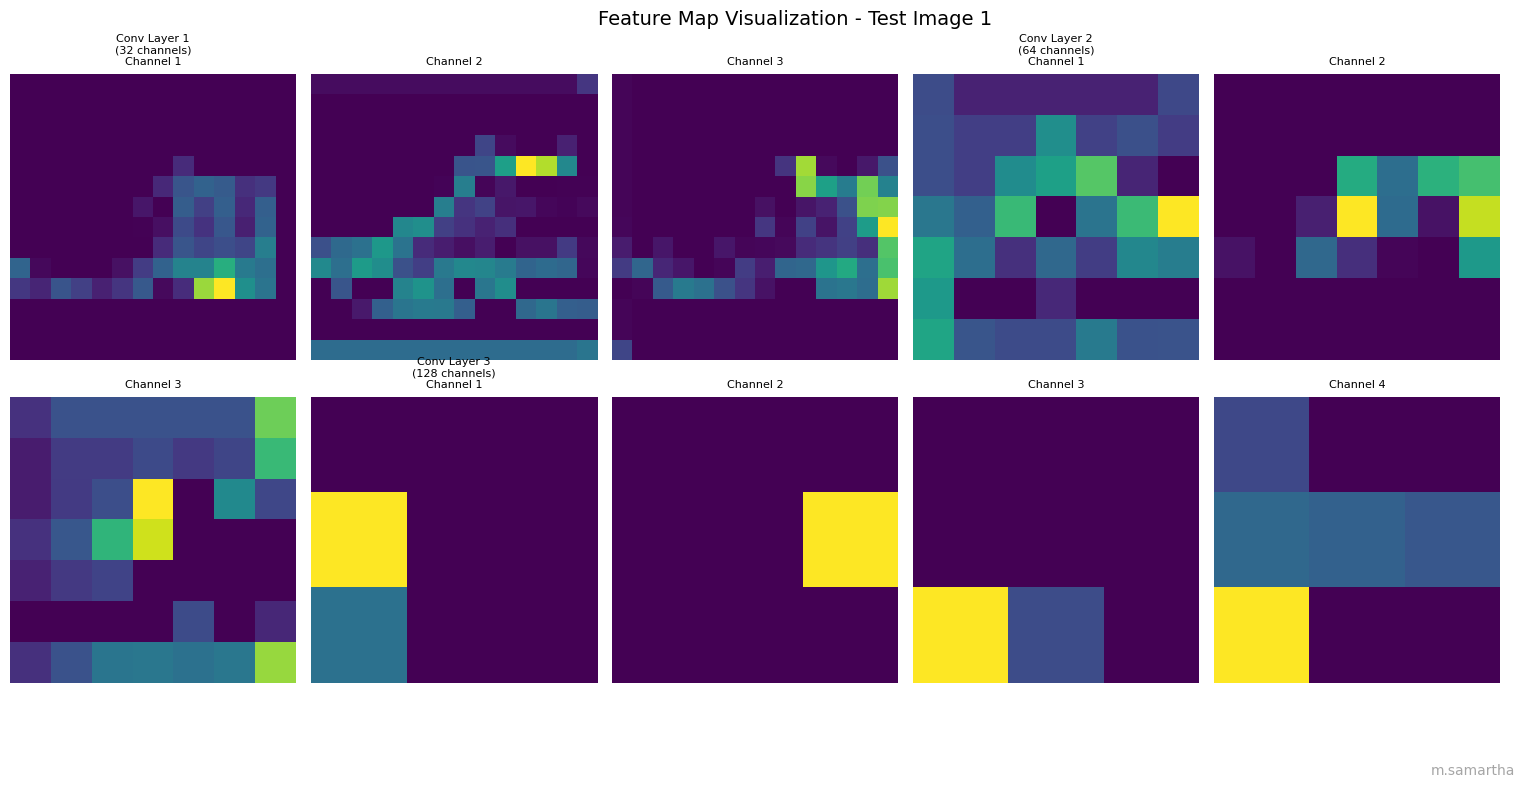

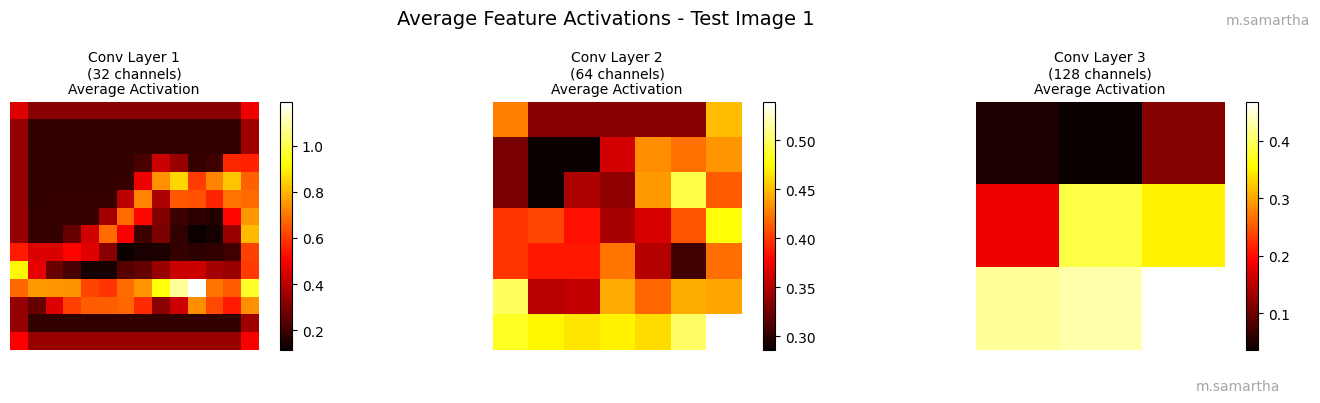

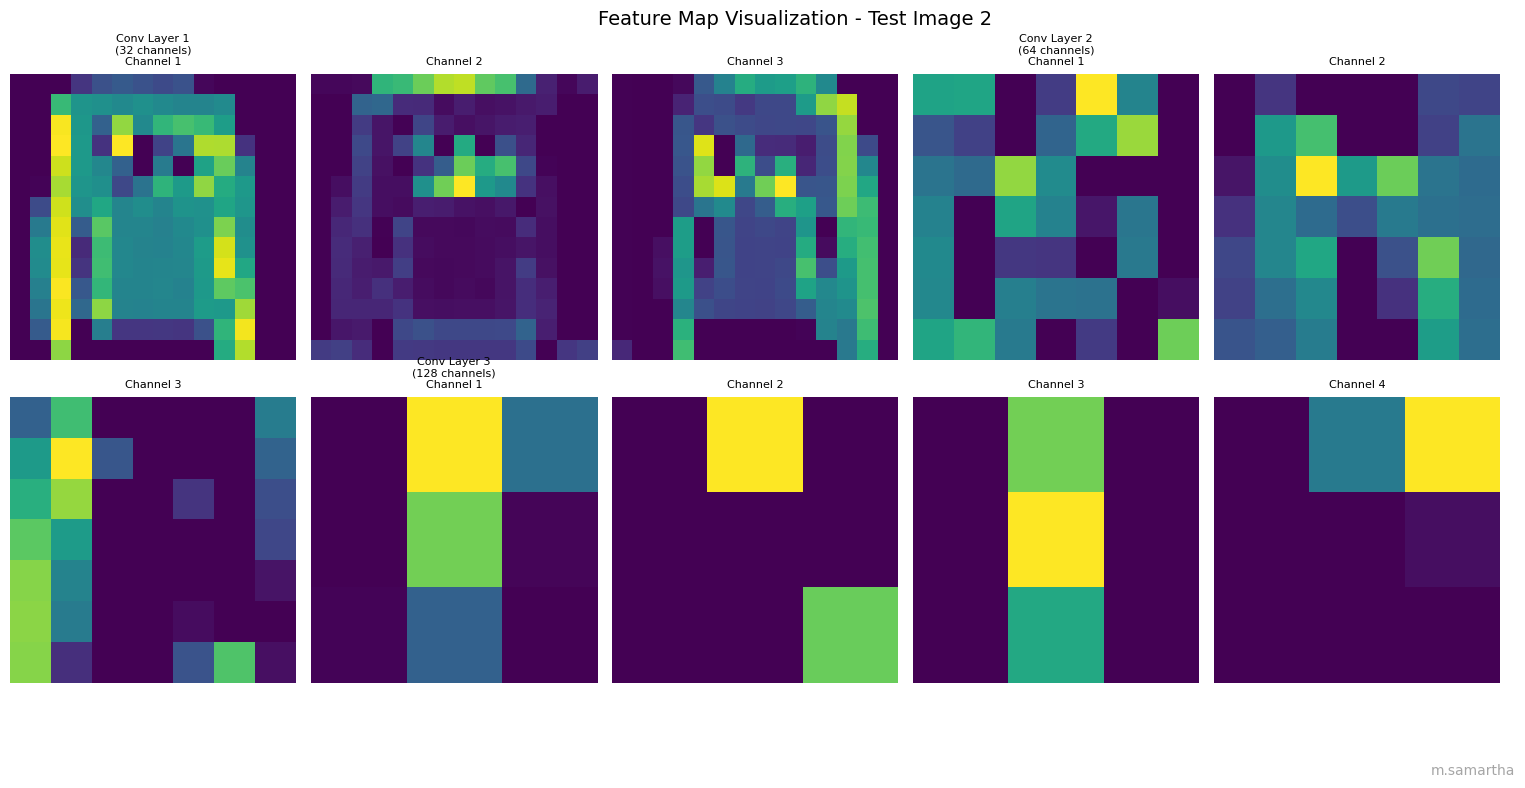

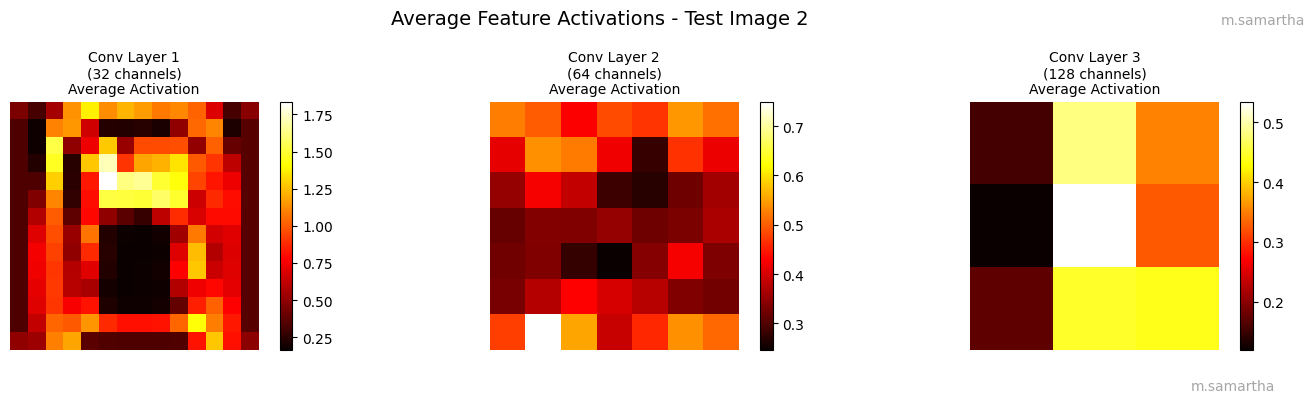

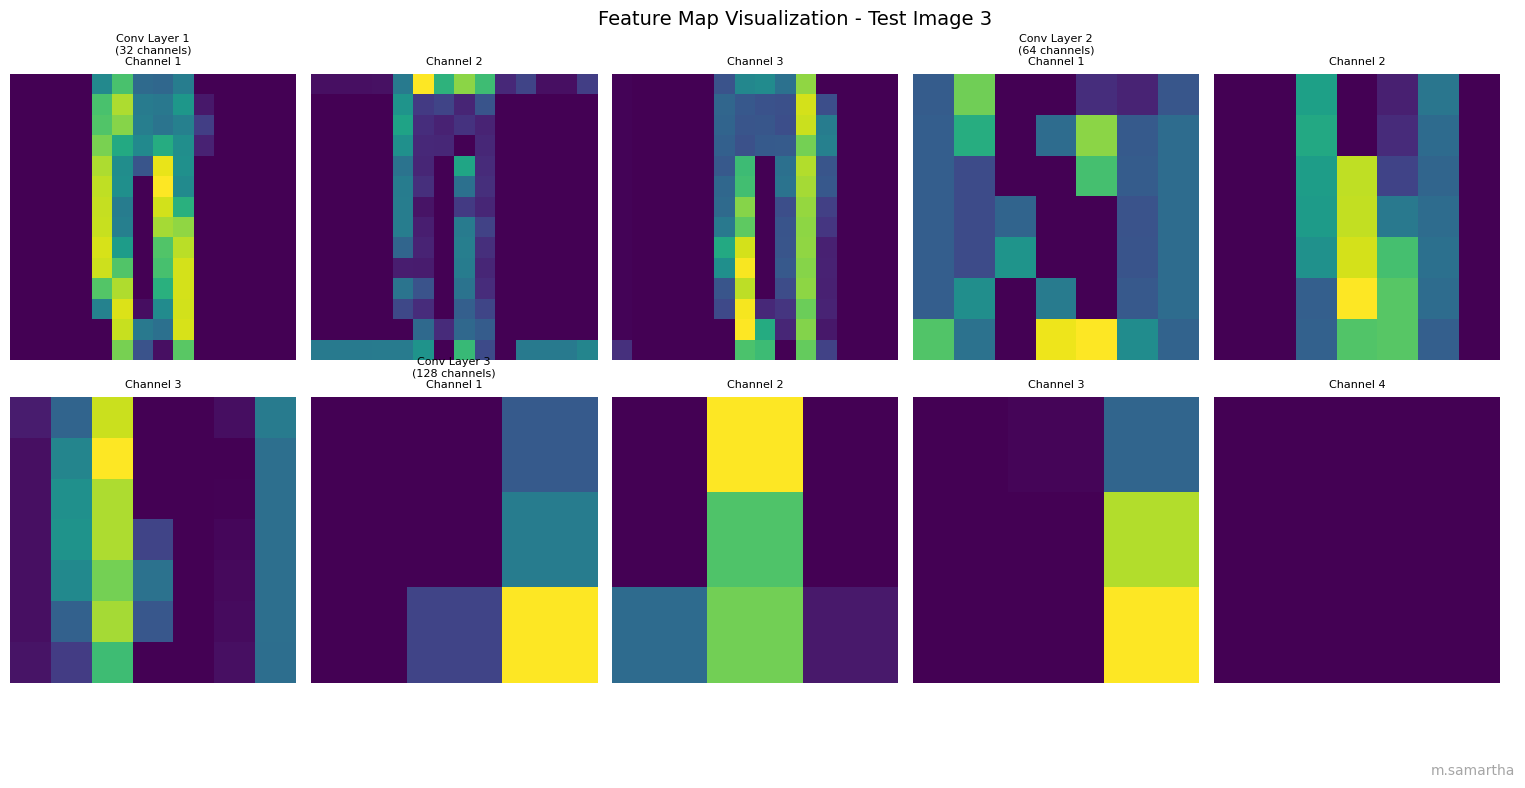

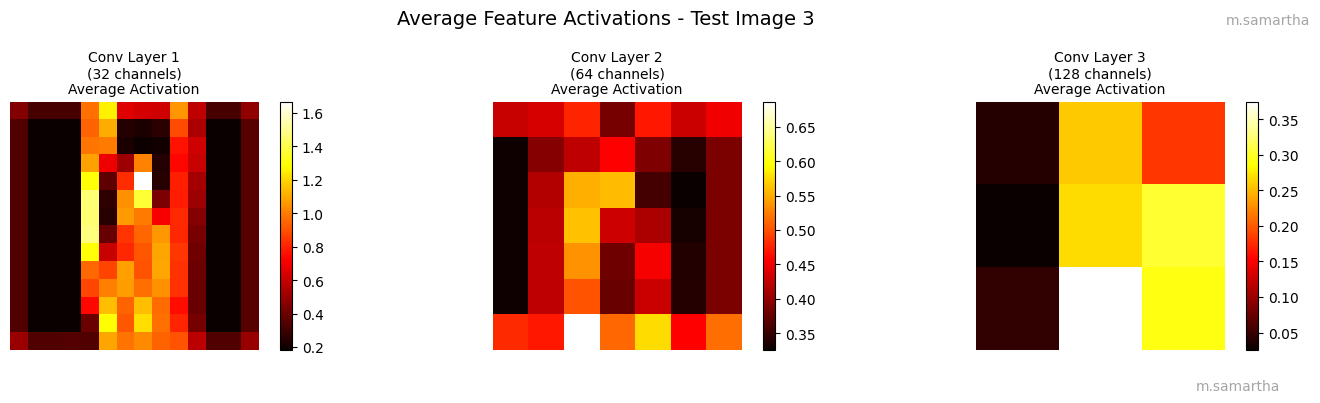

In [42]:
def visualize_feature_maps(model, test_loader, num_images=3, device='cpu'):
    """
    Visualize feature maps from different convolutional layers.
    
    Args:
        model: Trained CNN model
        test_loader: DataLoader with test images
        num_images: Number of test images to visualize
        device: Device to run on
    """
    model.eval()
    
    # Get a batch of test images
    dataiter = iter(test_loader)
    images, labels, ink_values = next(dataiter)
    
    # Select specific images to visualize
    images = images[:num_images].to(device)
    labels = labels[:num_images]
    ink_values = ink_values[:num_images]
    
    # Forward pass with feature extraction
    with torch.no_grad():
        class_logits, reg_output, feature_maps = model(images, return_features=True)
    
    # Get predictions
    preds = torch.argmax(class_logits, dim=1)
    
    # Visualize for each image
    for img_idx in range(num_images):
        fig = plt.figure(figsize=(16, 8))
        
        # Original image
        ax = plt.subplot(2, 5, 1)
        img = images[img_idx].cpu().squeeze()
        # Denormalize
        img = img * 0.3530 + 0.2860
        img = torch.clamp(img, 0, 1)
        ax.imshow(img, cmap='gray')
        ax.set_title(f'Original Image\nTrue: {class_names[labels[img_idx]]}\n' + 
                    f'Pred: {class_names[preds[img_idx]]}\n' +
                    f'Ink: {ink_values[img_idx]:.3f}', fontsize=9)
        ax.axis('off')
        
        # Feature maps from each layer
        layer_names = ['Conv Layer 1\n(32 channels)', 
                      'Conv Layer 2\n(64 channels)', 
                      'Conv Layer 3\n(128 channels)']
        
        for layer_idx, (fmap, layer_name) in enumerate(zip(feature_maps, layer_names)):
            # Get feature map for current image
            fmap_img = fmap[img_idx].cpu()
            
            # Show multiple channels (first 4)
            num_channels_to_show = min(4, fmap_img.shape[0])
            
            for ch_idx in range(num_channels_to_show):
                ax = plt.subplot(2, 5, layer_idx * 3 + ch_idx + 2 - 1)
                channel = fmap_img[ch_idx]
                ax.imshow(channel, cmap='viridis')
                if ch_idx == 0:
                    ax.set_title(f'{layer_name}\nChannel {ch_idx+1}', fontsize=8)
                else:
                    ax.set_title(f'Channel {ch_idx+1}', fontsize=8)
                ax.axis('off')
        
        plt.suptitle(f'Feature Map Visualization - Test Image {img_idx+1}', 
                    fontsize=14, y=0.98)
        plt.text(0.95, 0.02, username, ha='right', va='bottom', 
                transform=fig.transFigure, fontsize=10, color='gray', alpha=0.7)
        plt.tight_layout()
        plt.show()
        
        # Additional visualization: Average activation per layer
        fig, axes = plt.subplots(1, 3, figsize=(15, 4))
        for layer_idx, (fmap, layer_name) in enumerate(zip(feature_maps, layer_names)):
            fmap_img = fmap[img_idx].cpu()
            # Average across all channels
            avg_activation = fmap_img.mean(dim=0)
            im = axes[layer_idx].imshow(avg_activation, cmap='hot')
            axes[layer_idx].set_title(f'{layer_name}\nAverage Activation', fontsize=10)
            axes[layer_idx].axis('off')
            plt.colorbar(im, ax=axes[layer_idx], fraction=0.046)
        
        plt.suptitle(f'Average Feature Activations - Test Image {img_idx+1}', 
                    fontsize=14)
        plt.text(0.95, 0.02, username, ha='right', va='bottom',
                transform=fig.transFigure, fontsize=10, color='gray', alpha=0.7)
        plt.tight_layout()
        add_username_fig(username, fig)
        plt.show()

# Visualize feature maps using the best classification model
print("Visualizing feature maps from the best classification model...")
# load model from MODEL_SAVE_PATH
best_model = MultiTaskCNN(
    base_filters=BEST_CONFIG["base_filters"],
    num_blocks=BEST_CONFIG["num_blocks"],
    dropout_rate=BEST_CONFIG["dropout_rate"]
).to(device)
best_model.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=device))

visualize_feature_maps(best_model, test_loader, num_images=3, device=device)

### Interpretation 

=== Feature Map Interpretation ===
Conv Block 1 (Early layers):
  - Captures low-level features: edges, corners, simple textures
  - Detects basic shapes and contours of clothing items
  - Responds to intensity gradients important for ink regression

Conv Block 2 (Middle layers):
  - Combines edges into more complex patterns
  - Detects clothing-specific textures (fabric patterns, stitching)
  - Begins to recognize parts of garments (collars, sleeves, straps)

Conv Block 3 (Deep layers):
  - Captures high-level semantic features
  - Recognizes specific clothing regions and overall garment structure
  - Provides abstract representations useful for both classification and ink prediction
  - Helps distinguish between similar categories (shirts vs. t-shirts)